[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/awaliaaaa23/Final-Project-AMS-2025/blob/main/Capstone_Final_Project_AMS_2025.ipynb)

# ***Capstone Final Project Analisis Media Sosial***

| NIM | Nama | Deskripsi |
| -------- | -------- | -------- |
|11220940000053  |USWATUN HASANAH| Ambil Data, Labelling, Visualisasi, PPT, Presentasi|
|11220940000056  |SYAFIQAH MARSYA KHOLIYADI |Ambil Data, Labelling, Visualisasi, PPT, Presentasi|
|11220940000063   |AWALIA DAMAYANTI  | Ambil Data, Labelling, Visualisasi, PPT, Presentasi|







## Latar Belakang

  Aksi boikot produk oleh netizen Indonesia di media sosial semakin masif dilakukan, dipicu oleh isu genosida yang dilakukan Israel terhadap palestina. Kampanye boikot tersebut kerap viral di berbagai platform media sosial salah satunya di YouTube, hal ini berdampak langsung pada reputasi brand dan kepercayaan konsumen yang dapat mempengaruhi  hasil penjualan. Perusahaan yang terdampak, seperti Starbucks, Unilever, MCD, dll., perlu memahami bagaimana sentimen publik berkembang agar dapat merespons secara tepat. Dalam hal ini, analisis sentimen netizen menjadi penting untuk menggambarkan persepsi publik, mengidentifikasi isu utama, serta memberikan rekomendasi dari insight yang diperoleh agar dapat digunakan oleh perusahaan dalam pengambilan keputusan untuk mitigasi dampak dari aksi boikot.

## Rumusan Masalah

**Permasalahan**

1. Bagaimana tren sentimen netizen terhadap produk yang terkena boikot di media sosial dalam periode tertentu?

2. Apa isu utama yang muncul dalam percakapan netizen terkait boikot tersebut?

3. Apa saja insight dan rekomendasi bisnis yang dapat diberikan kepada perusahaan terkait agar dapat merespons atau memitigasi dampak dari boikot tersebut?



**Periode Pengumpulan Data**

17 Oktober 2023 - 15 Juli 2025

**Sumber Data**

YouTube

**Kata Kunci**
* #produkisrael
* #boikotprodukisrael
* #aksiboikot
* #penggantiprodukisrel
* #boikotkfc
* #boikotunilever
* #boikotstarbuck
* #dampakboikot



## Packages

In [137]:
!pip install sastrawi
!pip install emoji # Install the emoji library
!pip install textblob
from textblob import TextBlob
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import emoji

nltk.download('popular')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

# **Mempersiapkan Data**

## Pengambilan Data YouTube

Kami menggunakan 8 keyword dan melakukan proses pengambilan komentar di video youtobe secara acak menggunakan API




```
# Pengambilan yang kami lakukan
import csv
from datetime import datetime
import googleapiclient.discovery

api_key = "your-api-key"

keywords = ['#produkisrael',
'#boikotprodukisrael',
'#aksiboikot',
'#penggantiprodukisrael',
"#boikotkfc",
'#boikotunilever',
'#boikotstarbuck',
'#dampakboikot']

used_video_ids = set()  # Untuk menyimpan video yang sudah dipakai

def search_and_get_comments(search_query, max_videos=10, max_comments_per_video=250, start_date=None, end_date=None, csv_filename="youtube_comments.csv"):
    youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=api_key)

    search_response = youtube.search().list(
        part="snippet",
        q=search_query,
        type="video",
        maxResults=30  # ambil lebih banyak untuk jaga-jaga (nanti kita filter jadi 10 unik)
    ).execute()

    # Filter video yang belum dipakai
    video_titles_and_ids = {}
    for item in search_response['items']:
        if item['id']['kind'] == 'youtube#video':
            video_id = item['id']['videoId']
            if video_id not in used_video_ids:
                video_titles_and_ids[video_id] = item['snippet']['title']
                if len(video_titles_and_ids) >= max_videos:
                    break

    used_video_ids.update(video_titles_and_ids.keys())  # Tandai video ini sudah terpakai

    if not video_titles_and_ids:
        print(f"No new videos found for keyword '{search_query}'. Skipping.")
        return

    total_comments = 0
    unique_comments = set()

    start_dt = datetime.strptime(start_date, "%Y-%m-%d") if start_date else None
    end_dt = datetime.strptime(end_date, "%Y-%m-%d") if end_date else None

    with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["keyword", "video_id", "video_title", "comment_text", "published_at"])  # Header

        for video_id, video_title in video_titles_and_ids.items():
            try:
                next_page_token = None
                comments_written = 0

                while True:
                    request = youtube.commentThreads().list(
                        part="snippet",
                        videoId=video_id,
                        maxResults=100,
                        pageToken=next_page_token
                    )
                    response = request.execute()

                    for item in response['items']:
                        try:
                            snippet = item['snippet']['topLevelComment']['snippet']
                            comment_text = snippet['textDisplay']
                            published_at = snippet['publishedAt']
                            comment_dt = datetime.strptime(published_at, "%Y-%m-%dT%H:%M:%SZ")

                            if (start_dt and comment_dt < start_dt) or (end_dt and comment_dt > end_dt):
                                continue

                            unique_id = f"{video_id}_{comment_text}"
                            if unique_id in unique_comments:
                                continue
                            unique_comments.add(unique_id)

                            writer.writerow([search_query, video_id, video_title, comment_text, published_at])
                            total_comments += 1
                            comments_written += 1

                            if comments_written >= max_comments_per_video:
                                break
                        except KeyError:
                            continue

                    next_page_token = response.get("nextPageToken")
                    if not next_page_token or comments_written >= max_comments_per_video:
                        break

            except Exception as e:
                print(f"Error retrieving comments for video ID {video_id}: {e}")

    print(f"CSV file '{csv_filename}' created for keyword '{search_query}'.")
    print(f"Total unique comments retrieved: {total_comments}")
    print(f"Number of videos fetched: {len(video_titles_and_ids)}")

# Run for all keywords
start_date = "2023-10-7"
end_date = "2025-07-15"

for keyword in keywords:
    csv_file = f"youtube_comments_{keyword.replace(' ', '_')}.csv"
    search_and_get_comments(keyword, max_videos=10, max_comments_per_video=250, start_date=start_date, end_date=end_date, csv_filename=csv_file)

     
```




Setelah mengambil data di YouTube lalu kami lakukan proses penggabungan dan buang komentar duplikat agar satu keyword mengambil video yang berbeda dari yang lain.


```
import pandas as pd
import glob

# Mencari semua file CSV di dalam folder 'tweets-data'
csv_files = glob.glob('tweets-data/*.csv') # list nama file yang disimpan
csv_files.sort()  # Use the sort() method of the list object

n = 0
for filename in csv_files: ## Menggabungkan file csv dalam bentuk dataframe
  # Read the CSV file into a pandas DataFrame
  if n == 0:
    df = pd.read_csv(filename, delimiter=",")
    n = 1
  else:
    df2 = pd.read_csv(filename, delimiter=",")
    df = pd.concat([df, df2])
    n+=1

# Membuang duplikat berdasarkan id_str
df.drop_duplicates(subset=['id_str'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

# Ekspor Data Hasil Scrapping
from google.colab import files
namafile = "DATAX_Naturalisasi_fix.csv"
df.to_csv(namafile, index=False)
files.download(namafile)
"Exported"
```



## Import Data

Berikut Link hasil pengambilan data dari youtobe:
- https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/refs/heads/main/all_youtube_comments.csv


In [138]:
# Import data hasil pengambilan dari youtobe
import pandas as pd

# URL file raw CSV dari GitHub
url = 'https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/refs/heads/main/all_youtube_comments.csv'

# Membaca file langsung dari URL
dataRaw = pd.read_csv(url, low_memory=False, encoding='utf8')

# Menampilkan beberapa baris pertama
dataRaw.head()

keyword     video_id  \
0  #boikotstarbuck  07TnYABFVXI   
1  #boikotstarbuck  07TnYABFVXI   
2  #boikotstarbuck  07TnYABFVXI   
3  #boikotstarbuck  07TnYABFVXI   
4  #boikotstarbuck  07TnYABFVXI   

                                         video_title  \
0  Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1  Starbucks Oleng. Karena Boikot? Schultz Bilang...   
2  Starbucks Oleng. Karena Boikot? Schultz Bilang...   
3  Starbucks Oleng. Karena Boikot? Schultz Bilang...   
4  Starbucks Oleng. Karena Boikot? Schultz Bilang...   

                                        comment_text          published_at  
0                  Starbucks dukung LGBT.mari boikot  2025-07-09T07:39:42Z  
1  starbug itu kopi shop apa an sich,gk jelas.......  2025-06-21T08:28:00Z  
2  imigran timteng memang gila, berhasil menarik ...  2025-06-20T00:33:48Z  
3  Kmu beli satu kopi sama aja mengirim 1 peluru ...  2025-06-10T17:17:52Z  
4  The power of key is stand with palestine or le...  2025-04-10T10:00:58Z

In [139]:
# melihat kolom di dataRaw
dataRaw.columns

Index(['keyword', 'video_id', 'video_title', 'comment_text', 'published_at'], dtype='object')

## Preprocessing

### Menambahkan labelling ke dalam Dataset

Dari data komentar yang telah didapatkan, kami labelling dan buang komentar yang tidak berbahasa indonesia serta komentar terindikasi judi online. Selanjutnya data tersebut disimpan di link github berikut :

https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/refs/heads/main/youtube_comments_labelling_no_judol.csv

Kami telah melakukan proses pelabelan sentimen (1:Positif / mendukudung penggunaan produk terboikot, 2:Netral, dan 3:Negatif / tidak mendukung penggunaan produk terboikot) pada setiap komentar sebelum data ini diunggah ke GitHub dan diimpor ke sini. Langkah ini dilakukan untuk mendukung analisis sentimen publik terkait topik Penggunaan Produk yang Terkena Boikot di Media Sosial

In [140]:
url2 = "https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/refs/heads/main/youtube_comments_labelling_no_judol.csv"
data = pd.read_csv(url2, low_memory=False, encoding='utf8')
data

keyword     video_id  \
0     #boikotstarbuck  07TnYABFVXI   
1     #boikotstarbuck  07TnYABFVXI   
2     #boikotstarbuck  07TnYABFVXI   
3     #boikotstarbuck  07TnYABFVXI   
4     #boikotstarbuck  07TnYABFVXI   
...               ...          ...   
6147       #boikotkfc  4pyU3-Ry5ks   
6148       #boikotkfc  4pyU3-Ry5ks   
6149       #boikotkfc  4pyU3-Ry5ks   
6150       #boikotkfc  4pyU3-Ry5ks   
6151       #boikotkfc  4pyU3-Ry5ks   

                                            video_title  \
0     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
2     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
3     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
4     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
...                                                 ...   
6147  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6148  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6149  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6150  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6151  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   

                                           comment_text          published_at  \
0                     Starbucks dukung LGBT.mari boikot  2025-07-09T07:39:42Z   
1     starbug itu kopi shop apa an sich,gk jelas.......  2025-06-21T08:28:00Z   
2     imigran timteng memang gila, berhasil menarik ...  2025-06-20T00:33:48Z   
3     Kmu beli satu kopi sama aja mengirim 1 peluru ...  2025-06-10T17:17:52Z   
4     Saya nggak tau bagaimana kok Starbucks bisa gi...  2025-03-21T01:15:54Z   
...                                                 ...                   ...   
6147                       Pertanyaanya Indonesia kapan  2024-04-30T17:29:06Z   
6148  Indo apa kabar ? Masih suka kah melihat anak2 ...  2024-04-30T16:25:40Z   
6149   ❤🇮🇱🇮🇱❤ ane boikot makanan dan restoran palestina  2024-04-30T16:04:55Z   
6150  Orang +62 nggak malu sama Malaysia yang udah b...  2024-04-30T16:01:26Z   
6151  ALHAMDULILLAH... Lanjutkan.. INDONESIA kapan m...  2024-04-30T15:58:42Z   

      label  Unnamed: 6  
0         3         NaN  
1         3         NaN  
2         2         NaN  
3         3         NaN  
4         3         NaN  
...     ...         ...  
6147      2         NaN  
6148      2         NaN  
6149      3         NaN  
6150      3         NaN  
6151      3         NaN  

[6152 rows x 7 columns]

In [141]:
# Drop kolom yang tidak diperlukan
data = data.drop(columns=['video_id'])
# Ubah urutan kolom: published_at di awal, sisanya diikuti
cols = ['published_at', 'keyword', 'video_title', 'comment_text', 'label']
data = data[cols]

data

published_at          keyword  \
0     2025-07-09T07:39:42Z  #boikotstarbuck   
1     2025-06-21T08:28:00Z  #boikotstarbuck   
2     2025-06-20T00:33:48Z  #boikotstarbuck   
3     2025-06-10T17:17:52Z  #boikotstarbuck   
4     2025-03-21T01:15:54Z  #boikotstarbuck   
...                    ...              ...   
6147  2024-04-30T17:29:06Z       #boikotkfc   
6148  2024-04-30T16:25:40Z       #boikotkfc   
6149  2024-04-30T16:04:55Z       #boikotkfc   
6150  2024-04-30T16:01:26Z       #boikotkfc   
6151  2024-04-30T15:58:42Z       #boikotkfc   

                                            video_title  \
0     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
2     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
3     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
4     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
...                                                 ...   
6147  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6148  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6149  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6150  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6151  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   

                                           comment_text  label  
0                     Starbucks dukung LGBT.mari boikot      3  
1     starbug itu kopi shop apa an sich,gk jelas.......      3  
2     imigran timteng memang gila, berhasil menarik ...      2  
3     Kmu beli satu kopi sama aja mengirim 1 peluru ...      3  
4     Saya nggak tau bagaimana kok Starbucks bisa gi...      3  
...                                                 ...    ...  
6147                       Pertanyaanya Indonesia kapan      2  
6148  Indo apa kabar ? Masih suka kah melihat anak2 ...      2  
6149   ❤🇮🇱🇮🇱❤ ane boikot makanan dan restoran palestina      3  
6150  Orang +62 nggak malu sama Malaysia yang udah b...      3  
6151  ALHAMDULILLAH... Lanjutkan.. INDONESIA kapan m...      3  

[6152 rows x 5 columns]

### Duplikasi Data

In [142]:
# Menampilkan comment text yang duplikat
duplicate_count = data.duplicated(subset='comment_text').sum()
print(f"Jumlah komentar duplikat: {duplicate_count}")

Jumlah komentar duplikat: 49


In [143]:
# Menampilkan contoh komentar duplikat dalam bentuk tabel
data[data.duplicated(subset='comment_text', keep=False)].head(86)

published_at          keyword  \
105   2024-06-14T06:49:45Z  #boikotstarbuck   
114   2024-06-13T14:54:17Z  #boikotstarbuck   
117   2024-06-12T23:30:45Z  #boikotstarbuck   
268   2024-06-06T07:45:31Z  #boikotstarbuck   
290   2024-05-13T04:56:47Z  #boikotstarbuck   
...                    ...              ...   
5961  2024-05-04T05:00:54Z       #boikotkfc   
5962  2024-05-04T04:52:18Z       #boikotkfc   
6037  2025-06-10T03:40:36Z       #boikotkfc   
6076  2024-05-08T17:45:30Z       #boikotkfc   
6117  2024-05-01T11:06:33Z       #boikotkfc   

                                            video_title   comment_text  label  
105   Starbucks Oleng. Karena Boikot? Schultz Bilang...            NaN      2  
114   Starbucks Oleng. Karena Boikot? Schultz Bilang...         😂😂😂😂😂😂      2  
117   Starbucks Oleng. Karena Boikot? Schultz Bilang...   Tetap boikot      3  
268   Massa Gerebek Starbucks, Serukan Bela Palestin...      Lanjutkan      3  
290   Saham Starbucks Anjlok Akibat Boikot! #boikot ...            👍👍👍      2  
...                                                 ...            ...    ...  
5961                  KFC TUTUP BUKAN DISEBABKAN BOIKOT  Alhamdulillah      2  
5962                  KFC TUTUP BUKAN DISEBABKAN BOIKOT           😂😂😂😂      2  
6037  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...          Bagus      2  
6076  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...  Alhamdulillah      2  
6117  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...              🎉      2  

[78 rows x 5 columns]

In [144]:
# Menghapus Duplikat
data.drop_duplicates(subset='comment_text', inplace=True)

In [145]:
# Cek kembali yang Duplikat
duplicate_count = data.duplicated(subset='comment_text').sum()
print(f"Jumlah komentar duplikat: {duplicate_count}")

Jumlah komentar duplikat: 0


In [146]:
# Menyimpan dalam bentuk CSV untuk data tanpa komen yanng duplikat
# dataRaw.to_csv('comments_no_duplicates.csv', index=False)
#tidak perlu disimpan kalau dirunning

### Ubah Tipe Data

In [147]:
# Cek tipe data
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6103 entries, 0 to 6151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   published_at  6103 non-null   object
 1   keyword       6103 non-null   object
 2   video_title   6103 non-null   object
 3   comment_text  6102 non-null   object
 4   label         6103 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 286.1+ KB


In [148]:
# Ubah 'keyword' dan 'label' menjadi kategori
data['label'] = data['label'].astype('category')
data['keyword'] = data['keyword'].astype('category')

# Ubah 'published_at' menjadi datetime (format ISO 8601 ke waktu biasa)
data['published_at'] = pd.to_datetime(data['published_at'], format='%Y-%m-%dT%H:%M:%SZ')

# Cek hasil
data.dtypes

published_at    datetime64[ns]
keyword               category
video_title             object
comment_text            object
label                 category
dtype: object

In [149]:
# Cek jumlah tiap label
data['label'].value_counts()

label
2    2654
3    1997
1    1452
Name: count, dtype: int64

### Missing Value

In [150]:
# Cek Missing Value
data.isnull().sum()

published_at    0
keyword         0
video_title     0
comment_text    1
label           0
dtype: int64

In [151]:
# Menghapus baris yang memiliki missing value
data = data.dropna()

# Mengecek ulang apakah masih ada missing value
print(data.isnull().sum())

published_at    0
keyword         0
video_title     0
comment_text    0
label           0
dtype: int64


# **Cleaning Text**

In [152]:
# Membersihkan teks dari URL, mention, emoji, hashtag, angka, tanda baca, dan spasi berlebih
import re
import string
import unicodedata
import emoji

def clean_text(text):
    text = text.lower()

    # Hilangkan karakter aneh (emoji, simbol asing)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Hapus URL, mention, hashtag
    text = re.sub(r'http\S+|www.\S+', '', text)       # URL
    text = re.sub(r'@\w+', '', text)                  # mention
    text = re.sub(r'#\w+', '', text)                  # hashtag

    # Hapus emoji
    text = emoji.replace_emoji(text, replace='')

    # Hapus angka
    text = re.sub(r'\d+', ' ', text)

    # Ganti semua tanda baca dengan spasi, bukan hapus
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [153]:
# Membersihkan semua teks dalam kolom comment_text
data['cleaned_text'] = data['comment_text'].apply(clean_text)
data

published_at          keyword  \
0    2025-07-09 07:39:42  #boikotstarbuck   
1    2025-06-21 08:28:00  #boikotstarbuck   
2    2025-06-20 00:33:48  #boikotstarbuck   
3    2025-06-10 17:17:52  #boikotstarbuck   
4    2025-03-21 01:15:54  #boikotstarbuck   
...                  ...              ...   
6147 2024-04-30 17:29:06       #boikotkfc   
6148 2024-04-30 16:25:40       #boikotkfc   
6149 2024-04-30 16:04:55       #boikotkfc   
6150 2024-04-30 16:01:26       #boikotkfc   
6151 2024-04-30 15:58:42       #boikotkfc   

                                            video_title  \
0     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
2     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
3     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
4     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
...                                                 ...   
6147  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6148  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6149  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6150  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6151  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   

                                           comment_text label  \
0                     Starbucks dukung LGBT.mari boikot     3   
1     starbug itu kopi shop apa an sich,gk jelas.......     3   
2     imigran timteng memang gila, berhasil menarik ...     2   
3     Kmu beli satu kopi sama aja mengirim 1 peluru ...     3   
4     Saya nggak tau bagaimana kok Starbucks bisa gi...     3   
...                                                 ...   ...   
6147                       Pertanyaanya Indonesia kapan     2   
6148  Indo apa kabar ? Masih suka kah melihat anak2 ...     2   
6149   ❤🇮🇱🇮🇱❤ ane boikot makanan dan restoran palestina     3   
6150  Orang +62 nggak malu sama Malaysia yang udah b...     3   
6151  ALHAMDULILLAH... Lanjutkan.. INDONESIA kapan m...     3   

                                           cleaned_text  
0                     starbucks dukung lgbt mari boikot  
1     starbug itu kopi shop apa an sich gk jelas pin...  
2     imigran timteng memang gila berhasil menarik s...  
3     kmu beli satu kopi sama aja mengirim peluru ke...  
4     saya nggak tau bagaimana kok starbucks bisa gi...  
...                                                 ...  
6147                       pertanyaanya indonesia kapan  
6148  indo apa kabar masih suka kah melihat anak tek...  
6149          ane boikot makanan dan restoran palestina  
6150  orang nggak malu sama malaysia yang udah beran...  
6151  alhamdulillah lanjutkan indonesia kapan mau tu...  

[6102 rows x 6 columns]

## Normalisasi Data

In [154]:
# Buat folder data
!mkdir -p data
!wget -P data/ https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/main/Data_Slang_%26_Typo%20List.txt

# Lokasi file
slang_file = 'data/Data_Slang_&_Typo List.txt'

# Membuat kamus slang dari file
slang_dict = {}
with open(slang_file, 'r', encoding='utf-8') as file:
    for line in file:
        if ':' in line:
            slang, standard = line.strip().split(':', 1)
            slang_dict[slang.strip()] = standard.strip()

# Pastikan sudah import word_tokenize (dari NLTK)
from nltk.tokenize import word_tokenize

# Fungsi untuk mengganti slang dengan kata baku
def normalize_slang(text):
    words = word_tokenize(text.lower())
    return ' '.join([slang_dict.get(word, word) for word in words])

# Terapkan ke kolom 'cleaned_text'
data['normalized_comment'] = data['cleaned_text'].apply(normalize_slang)

# Lihat hasil
data[['cleaned_text', 'normalized_comment']].head()

--2025-07-17 17:21:39--  https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/main/Data_Slang_%26_Typo%20List.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82941 (81K) [text/plain]
Saving to: ‘data/Data_Slang_&_Typo List.txt.3’

Data_Slang_&_Typo L 100%[===================>]  81.00K  --.-KB/s    in 0.003s  

2025-07-17 17:21:39 (29.6 MB/s) - ‘data/Data_Slang_&_Typo List.txt.3’ saved [82941/82941]



cleaned_text  \
0                  starbucks dukung lgbt mari boikot   
1  starbug itu kopi shop apa an sich gk jelas pin...   
2  imigran timteng memang gila berhasil menarik s...   
3  kmu beli satu kopi sama aja mengirim peluru ke...   
4  saya nggak tau bagaimana kok starbucks bisa gi...   

                                  normalized_comment  
0                  starbucks dukung lgbt mari boikot  
1  starbucks itu kopi shop apa an sih tidak jelas...  
2  imigran timurtengah memang gila berhasil menar...  
3  kamu beli satu kopi sama saja mengirim peluru ...  
4  saya tidak tahu bagaimana sih starbucks bisa b...

In [155]:
# Cek isi data
data

published_at          keyword  \
0    2025-07-09 07:39:42  #boikotstarbuck   
1    2025-06-21 08:28:00  #boikotstarbuck   
2    2025-06-20 00:33:48  #boikotstarbuck   
3    2025-06-10 17:17:52  #boikotstarbuck   
4    2025-03-21 01:15:54  #boikotstarbuck   
...                  ...              ...   
6147 2024-04-30 17:29:06       #boikotkfc   
6148 2024-04-30 16:25:40       #boikotkfc   
6149 2024-04-30 16:04:55       #boikotkfc   
6150 2024-04-30 16:01:26       #boikotkfc   
6151 2024-04-30 15:58:42       #boikotkfc   

                                            video_title  \
0     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
2     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
3     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
4     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
...                                                 ...   
6147  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6148  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6149  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6150  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6151  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   

                                           comment_text label  \
0                     Starbucks dukung LGBT.mari boikot     3   
1     starbug itu kopi shop apa an sich,gk jelas.......     3   
2     imigran timteng memang gila, berhasil menarik ...     2   
3     Kmu beli satu kopi sama aja mengirim 1 peluru ...     3   
4     Saya nggak tau bagaimana kok Starbucks bisa gi...     3   
...                                                 ...   ...   
6147                       Pertanyaanya Indonesia kapan     2   
6148  Indo apa kabar ? Masih suka kah melihat anak2 ...     2   
6149   ❤🇮🇱🇮🇱❤ ane boikot makanan dan restoran palestina     3   
6150  Orang +62 nggak malu sama Malaysia yang udah b...     3   
6151  ALHAMDULILLAH... Lanjutkan.. INDONESIA kapan m...     3   

                                           cleaned_text  \
0                     starbucks dukung lgbt mari boikot   
1     starbug itu kopi shop apa an sich gk jelas pin...   
2     imigran timteng memang gila berhasil menarik s...   
3     kmu beli satu kopi sama aja mengirim peluru ke...   
4     saya nggak tau bagaimana kok starbucks bisa gi...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indo apa kabar masih suka kah melihat anak tek...   
6149          ane boikot makanan dan restoran palestina   
6150  orang nggak malu sama malaysia yang udah beran...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                     normalized_comment  
0                     starbucks dukung lgbt mari boikot  
1     starbucks itu kopi shop apa an sih tidak jelas...  
2     imigran timurtengah memang gila berhasil menar...  
3     kamu beli satu kopi sama saja mengirim peluru ...  
4     saya tidak tahu bagaimana sih starbucks bisa b...  
...                                                 ...  
6147                       pertanyaanya indonesia kapan  
6148  indonesia apa kabar masih suka kah melihat ana...  
6149         saya boikot makanan dan restoran palestina  
6150  orang tidak malu sama malaysia yang sudah bera...  
6151  alhamdulillah lanjutkan indonesia kapan mau tu...  

[6102 rows x 7 columns]

## Cleaning Data Lanjutan

In [156]:
# Membersihkan semua teks dalam kolom normalized_comment
data['cleaned_text2'] = data['normalized_comment'].apply(clean_text)
data

published_at          keyword  \
0    2025-07-09 07:39:42  #boikotstarbuck   
1    2025-06-21 08:28:00  #boikotstarbuck   
2    2025-06-20 00:33:48  #boikotstarbuck   
3    2025-06-10 17:17:52  #boikotstarbuck   
4    2025-03-21 01:15:54  #boikotstarbuck   
...                  ...              ...   
6147 2024-04-30 17:29:06       #boikotkfc   
6148 2024-04-30 16:25:40       #boikotkfc   
6149 2024-04-30 16:04:55       #boikotkfc   
6150 2024-04-30 16:01:26       #boikotkfc   
6151 2024-04-30 15:58:42       #boikotkfc   

                                            video_title  \
0     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
2     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
3     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
4     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
...                                                 ...   
6147  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6148  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6149  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6150  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6151  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   

                                           comment_text label  \
0                     Starbucks dukung LGBT.mari boikot     3   
1     starbug itu kopi shop apa an sich,gk jelas.......     3   
2     imigran timteng memang gila, berhasil menarik ...     2   
3     Kmu beli satu kopi sama aja mengirim 1 peluru ...     3   
4     Saya nggak tau bagaimana kok Starbucks bisa gi...     3   
...                                                 ...   ...   
6147                       Pertanyaanya Indonesia kapan     2   
6148  Indo apa kabar ? Masih suka kah melihat anak2 ...     2   
6149   ❤🇮🇱🇮🇱❤ ane boikot makanan dan restoran palestina     3   
6150  Orang +62 nggak malu sama Malaysia yang udah b...     3   
6151  ALHAMDULILLAH... Lanjutkan.. INDONESIA kapan m...     3   

                                           cleaned_text  \
0                     starbucks dukung lgbt mari boikot   
1     starbug itu kopi shop apa an sich gk jelas pin...   
2     imigran timteng memang gila berhasil menarik s...   
3     kmu beli satu kopi sama aja mengirim peluru ke...   
4     saya nggak tau bagaimana kok starbucks bisa gi...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indo apa kabar masih suka kah melihat anak tek...   
6149          ane boikot makanan dan restoran palestina   
6150  orang nggak malu sama malaysia yang udah beran...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                     normalized_comment  \
0                     starbucks dukung lgbt mari boikot   
1     starbucks itu kopi shop apa an sih tidak jelas...   
2     imigran timurtengah memang gila berhasil menar...   
3     kamu beli satu kopi sama saja mengirim peluru ...   
4     saya tidak tahu bagaimana sih starbucks bisa b...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indonesia apa kabar masih suka kah melihat ana...   
6149         saya boikot makanan dan restoran palestina   
6150  orang tidak malu sama malaysia yang sudah bera...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                          cleaned_text2  
0                     starbucks dukung lgbt mari boikot  
1     starbucks itu kopi shop apa an sih tidak jelas...  
2     imigran timurtengah memang gila berhasil menar...  
3     kamu beli satu kopi sama saja mengirim peluru ...  
4     saya tidak tahu bagaimana sih starbucks bisa b...  
...                                                 ...  
6147                       pertanyaanya indonesia kapan  
6148  indonesia apa kabar masih suka kah melihat ana...  
6149         saya boikot makanan dan rest

### Stopword

Sebelumnya kita sudah gabungkan semua stopword menjadi satu file dalam link berikut :

https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/refs/heads/main/stopwords%20list.txt


In [157]:
!wget -O data/stopwords_id.txt https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/main/stopwords%20list.txt
# Menghapus stopwords bahasa Indonesia
# Baca file stopwords
with open('data/stopwords_id.txt', "r", encoding="utf-8", errors='replace') as file:
    id_stop = file.readlines()

# Bersihkan stopwords (strip newline/spasi & lowercase)
id_stop = [word.strip().lower() for word in id_stop]

# Tambahkan kata-kata tambahan
additional_stopwords = {
    'nya', 'iya', 'itu', 'kah', 'dan', 'ke', 'di',
    'turun', 'naik', 'ambil', 'lihat',
    'tolong', 'atas', 'pokok', 'hari',
    'naikin', 'presiden', 'indonesia', 'sih', 'pakai',
    'biar', 'juta', 'ribu','tek'
}

# Gabungkan ke list utama
id_stop = set(id_stop).union(additional_stopwords)

# Fungsi hapus stopwords
def remove_custom_stopwords(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in id_stop])

# Terapkan ke kolom yang sudah dibersihkan sebelumnya
data['no_stopwords'] = data['cleaned_text2'].apply(remove_custom_stopwords)

# Lihat hasil
data

--2025-07-17 17:21:43--  https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/main/stopwords%20list.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7709 (7.5K) [text/plain]
Saving to: ‘data/stopwords_id.txt’

data/stopwords_id.t 100%[===================>]   7.53K  --.-KB/s    in 0s      

2025-07-17 17:21:43 (60.4 MB/s) - ‘data/stopwords_id.txt’ saved [7709/7709]



published_at          keyword  \
0    2025-07-09 07:39:42  #boikotstarbuck   
1    2025-06-21 08:28:00  #boikotstarbuck   
2    2025-06-20 00:33:48  #boikotstarbuck   
3    2025-06-10 17:17:52  #boikotstarbuck   
4    2025-03-21 01:15:54  #boikotstarbuck   
...                  ...              ...   
6147 2024-04-30 17:29:06       #boikotkfc   
6148 2024-04-30 16:25:40       #boikotkfc   
6149 2024-04-30 16:04:55       #boikotkfc   
6150 2024-04-30 16:01:26       #boikotkfc   
6151 2024-04-30 15:58:42       #boikotkfc   

                                            video_title  \
0     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
2     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
3     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
4     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
...                                                 ...   
6147  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6148  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6149  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6150  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6151  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   

                                           comment_text label  \
0                     Starbucks dukung LGBT.mari boikot     3   
1     starbug itu kopi shop apa an sich,gk jelas.......     3   
2     imigran timteng memang gila, berhasil menarik ...     2   
3     Kmu beli satu kopi sama aja mengirim 1 peluru ...     3   
4     Saya nggak tau bagaimana kok Starbucks bisa gi...     3   
...                                                 ...   ...   
6147                       Pertanyaanya Indonesia kapan     2   
6148  Indo apa kabar ? Masih suka kah melihat anak2 ...     2   
6149   ❤🇮🇱🇮🇱❤ ane boikot makanan dan restoran palestina     3   
6150  Orang +62 nggak malu sama Malaysia yang udah b...     3   
6151  ALHAMDULILLAH... Lanjutkan.. INDONESIA kapan m...     3   

                                           cleaned_text  \
0                     starbucks dukung lgbt mari boikot   
1     starbug itu kopi shop apa an sich gk jelas pin...   
2     imigran timteng memang gila berhasil menarik s...   
3     kmu beli satu kopi sama aja mengirim peluru ke...   
4     saya nggak tau bagaimana kok starbucks bisa gi...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indo apa kabar masih suka kah melihat anak tek...   
6149          ane boikot makanan dan restoran palestina   
6150  orang nggak malu sama malaysia yang udah beran...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                     normalized_comment  \
0                     starbucks dukung lgbt mari boikot   
1     starbucks itu kopi shop apa an sih tidak jelas...   
2     imigran timurtengah memang gila berhasil menar...   
3     kamu beli satu kopi sama saja mengirim peluru ...   
4     saya tidak tahu bagaimana sih starbucks bisa b...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indonesia apa kabar masih suka kah melihat ana...   
6149         saya boikot makanan dan restoran palestina   
6150  orang tidak malu sama malaysia yang sudah bera...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                          cleaned_text2  \
0                     starbucks dukung lgbt mari boikot   
1     starbucks itu kopi shop apa an sih tidak jelas...   
2     imigran timurtengah memang gila berhasil menar...   
3     kamu beli satu kopi sama saja mengirim peluru ...   
4     saya tidak tahu bagaimana sih starbucks bisa b...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indonesia apa kabar masih suka kah melihat ana...   
6149         saya boikot makanan

###Data Lemmatization

In [158]:
# Proses mengubah kata ke bentuk dasarnya (root word).
# Inisialisasi stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi stemming menggunakan Sastrawi
def stem_text(text):
    return stemmer.stem(text)

# Terapkan stemming pada kolom 'no_stopwords'
data['stemmed_text'] = data['no_stopwords'].apply(stem_text)

data

published_at          keyword  \
0    2025-07-09 07:39:42  #boikotstarbuck   
1    2025-06-21 08:28:00  #boikotstarbuck   
2    2025-06-20 00:33:48  #boikotstarbuck   
3    2025-06-10 17:17:52  #boikotstarbuck   
4    2025-03-21 01:15:54  #boikotstarbuck   
...                  ...              ...   
6147 2024-04-30 17:29:06       #boikotkfc   
6148 2024-04-30 16:25:40       #boikotkfc   
6149 2024-04-30 16:04:55       #boikotkfc   
6150 2024-04-30 16:01:26       #boikotkfc   
6151 2024-04-30 15:58:42       #boikotkfc   

                                            video_title  \
0     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
2     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
3     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
4     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
...                                                 ...   
6147  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6148  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6149  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6150  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6151  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   

                                           comment_text label  \
0                     Starbucks dukung LGBT.mari boikot     3   
1     starbug itu kopi shop apa an sich,gk jelas.......     3   
2     imigran timteng memang gila, berhasil menarik ...     2   
3     Kmu beli satu kopi sama aja mengirim 1 peluru ...     3   
4     Saya nggak tau bagaimana kok Starbucks bisa gi...     3   
...                                                 ...   ...   
6147                       Pertanyaanya Indonesia kapan     2   
6148  Indo apa kabar ? Masih suka kah melihat anak2 ...     2   
6149   ❤🇮🇱🇮🇱❤ ane boikot makanan dan restoran palestina     3   
6150  Orang +62 nggak malu sama Malaysia yang udah b...     3   
6151  ALHAMDULILLAH... Lanjutkan.. INDONESIA kapan m...     3   

                                           cleaned_text  \
0                     starbucks dukung lgbt mari boikot   
1     starbug itu kopi shop apa an sich gk jelas pin...   
2     imigran timteng memang gila berhasil menarik s...   
3     kmu beli satu kopi sama aja mengirim peluru ke...   
4     saya nggak tau bagaimana kok starbucks bisa gi...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indo apa kabar masih suka kah melihat anak tek...   
6149          ane boikot makanan dan restoran palestina   
6150  orang nggak malu sama malaysia yang udah beran...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                     normalized_comment  \
0                     starbucks dukung lgbt mari boikot   
1     starbucks itu kopi shop apa an sih tidak jelas...   
2     imigran timurtengah memang gila berhasil menar...   
3     kamu beli satu kopi sama saja mengirim peluru ...   
4     saya tidak tahu bagaimana sih starbucks bisa b...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indonesia apa kabar masih suka kah melihat ana...   
6149         saya boikot makanan dan restoran palestina   
6150  orang tidak malu sama malaysia yang sudah bera...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                          cleaned_text2  \
0                     starbucks dukung lgbt mari boikot   
1     starbucks itu kopi shop apa an sih tidak jelas...   
2     imigran timurtengah memang gila berhasil menar...   
3     kamu beli satu kopi sama saja mengirim peluru ...   
4     saya tidak tahu bagaimana sih starbucks bisa b...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indonesia apa kabar masih suka kah melihat ana...   
6149         saya boikot makanan

### Stopword lanjutan

In [159]:
# --- Kode untuk Top 100 Kata dari df_stemmed ---

from collections import Counter

all_words = []

# Iterasi melalui setiap entri di kolom 'stemmed_text'
# Menggunakan .dropna() untuk menghindari error jika ada nilai NaN
# Menggunakan .astype(str) untuk mengubah semua nilai menjadi string (mengantisipasi jika ada tipe data lain)
for text_entry in data['stemmed_text'].dropna().astype(str):
    if text_entry.strip():  # Memastikan string tidak kosong setelah di-strip
        # Jika isi 'stemmed_text' adalah string kata-kata yang dipisahkan spasi
        words = text_entry.split()
        all_words.extend(words)
        # Jika isi 'stemmed_text' sudah berupa list of words, Anda bisa langsung:
        # all_words.extend(text_entry) # Namun, ini memerlukan text_entry sudah pasti list

# Hitung frekuensi setiap kata
word_counts = Counter(all_words)

# Dapatkan 100 kata paling umum
top_100_words = word_counts.most_common(100)

print("--- Top 100 kata yang sering muncul dari 'stemmed_text' ---")
if top_100_words:
    for word, count in top_100_words:
        print(f"{word}: {count}")
else:
    print("Tidak ada kata untuk dihitung (mungkin semua entri kosong atau NaN).")
print("-" * 40)

--- Top 100 kata yang sering muncul dari 'stemmed_text' ---
boikot: 2125
israel: 2074
produk: 2061
orang: 863
kfc: 648
beli: 566
makan: 529
negara: 505
palestina: 436
kerja: 375
lokal: 370
dukung: 367
negeri: 304
usaha: 301
ayam: 292
yahudi: 228
rakyat: 222
dunia: 220
profesional: 219
ulama: 214
mcd: 208
islam: 199
amerika: 194
anak: 188
majelis: 188
manusia: 181
starbucks: 178
zionis: 176
harga: 175
bangsa: 167
cinta: 166
enak: 165
bagus: 164
barang: 163
hidup: 162
salah: 162
uang: 161
jual: 160
cari: 155
phk: 155
saudara: 153
facebook: 152
muslim: 151
perintah: 149
bantu: 148
kopi: 147
buat: 147
kasih: 146
haram: 146
maju: 145
brand: 142
youtube: 142
ekonomi: 141
rugi: 141
suka: 135
handphone: 134
tutup: 130
bikin: 129
google: 128
milik: 128
henti: 127
munafik: 127
agama: 123
masuk: 122
masyarakat: 121
pikir: 121
perang: 119
bank: 118
warga: 117
unilever: 117
ganti: 116
internet: 116
hamas: 115
pengaruh: 112
bicara: 112
karyawan: 111
murah: 109
ayo: 109
umat: 108
umkm: 105
bunuh: 103

In [160]:
# Tambahkan stopwords tambahan
additional_stopwords = {
    'adik', 'agama', 'ajar', 'ala', 'amp', 'anak', 'anggota', 'anggar', 'antem', 'apa', 'arti', 'asasi', 'bantu',
    'bawa', 'beda', 'bicara', 'bikin', 'bilang', 'bina', 'bukti', 'cari', 'coba', 'contoh', 'daerah', 'dewan',
    'diam', 'didik', 'disiplin', 'dukung', 'gaji buta', 'generasi', 'generasi muda', 'gubenur', 'hak', 'hasil',
    'henti', 'hormat', 'ide', 'ikut', 'jakarta', 'jalan', 'jaman', 'jabatan', 'jabat', 'kak seto', 'kali',
    'karakter', 'keluarga', 'kerja', 'kaya', 'kirim', 'khofifah', 'komentar', 'komisi', 'koruptor', 'lindung',
    'lihat', 'lembaga', 'lulus', 'langsung', 'malu', 'makan', 'makan gaji', 'manusia', 'masuk', 'masyarakat',
    'media', 'metropolitan', 'metropolitan televisi', 'mental', 'moga', 'mu', 'muda', 'murid', 'nama', 'nasional',
    'neng', 'negara', 'nilai', 'nol', 'nyata', 'omong', 'omon', 'omon omon', 'ono', 'otak', 'pas', 'penuh',
    'pikir', 'pilih', 'pimpin', 'pintar', 'republik', 'remaja', 'rg', 'rakyat', 'rumah', 'sila', 'sehat', 'sekolah',
    'sesuaI', 'si', 'smp', 'solusi', 'swt', 'tanggung', 'televisi', 'teman', 'tentara', 'teori', 'tinggal', 'timur',
    'tuju', 'tujuan', 'tuju', 'ubah', 'uang', 'umpat', 'umpat umpat', 'urus', 'wakil', 'wajib', 'warga', 'wudele',
    'nama', 'rocky'
}

# Gabungkan dengan stopwords yang sudah ada
id_stop = set(id_stop).union(additional_stopwords)

# Fungsi hapus stopwords dari list kata
def remove_custom_stopwords(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in id_stop])

# Terapkan ke kolom hasil lemmatization (yang sudah berupa list kata)
data['no_stopwords2'] = data['stemmed_text'].apply(remove_custom_stopwords)

data

published_at          keyword  \
0    2025-07-09 07:39:42  #boikotstarbuck   
1    2025-06-21 08:28:00  #boikotstarbuck   
2    2025-06-20 00:33:48  #boikotstarbuck   
3    2025-06-10 17:17:52  #boikotstarbuck   
4    2025-03-21 01:15:54  #boikotstarbuck   
...                  ...              ...   
6147 2024-04-30 17:29:06       #boikotkfc   
6148 2024-04-30 16:25:40       #boikotkfc   
6149 2024-04-30 16:04:55       #boikotkfc   
6150 2024-04-30 16:01:26       #boikotkfc   
6151 2024-04-30 15:58:42       #boikotkfc   

                                            video_title  \
0     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
2     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
3     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
4     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
...                                                 ...   
6147  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6148  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6149  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6150  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6151  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   

                                           comment_text label  \
0                     Starbucks dukung LGBT.mari boikot     3   
1     starbug itu kopi shop apa an sich,gk jelas.......     3   
2     imigran timteng memang gila, berhasil menarik ...     2   
3     Kmu beli satu kopi sama aja mengirim 1 peluru ...     3   
4     Saya nggak tau bagaimana kok Starbucks bisa gi...     3   
...                                                 ...   ...   
6147                       Pertanyaanya Indonesia kapan     2   
6148  Indo apa kabar ? Masih suka kah melihat anak2 ...     2   
6149   ❤🇮🇱🇮🇱❤ ane boikot makanan dan restoran palestina     3   
6150  Orang +62 nggak malu sama Malaysia yang udah b...     3   
6151  ALHAMDULILLAH... Lanjutkan.. INDONESIA kapan m...     3   

                                           cleaned_text  \
0                     starbucks dukung lgbt mari boikot   
1     starbug itu kopi shop apa an sich gk jelas pin...   
2     imigran timteng memang gila berhasil menarik s...   
3     kmu beli satu kopi sama aja mengirim peluru ke...   
4     saya nggak tau bagaimana kok starbucks bisa gi...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indo apa kabar masih suka kah melihat anak tek...   
6149          ane boikot makanan dan restoran palestina   
6150  orang nggak malu sama malaysia yang udah beran...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                     normalized_comment  \
0                     starbucks dukung lgbt mari boikot   
1     starbucks itu kopi shop apa an sih tidak jelas...   
2     imigran timurtengah memang gila berhasil menar...   
3     kamu beli satu kopi sama saja mengirim peluru ...   
4     saya tidak tahu bagaimana sih starbucks bisa b...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indonesia apa kabar masih suka kah melihat ana...   
6149         saya boikot makanan dan restoran palestina   
6150  orang tidak malu sama malaysia yang sudah bera...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                          cleaned_text2  \
0                     starbucks dukung lgbt mari boikot   
1     starbucks itu kopi shop apa an sih tidak jelas...   
2     imigran timurtengah memang gila berhasil menar...   
3     kamu beli satu kopi sama saja mengirim peluru ...   
4     saya tidak tahu bagaimana sih starbucks bisa b...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indonesia apa kabar masih suka kah melihat ana...   
6149         saya boikot makanan

In [161]:
# --- Kode untuk Top 100 Kata dari df_stemmed ---

from collections import Counter

all_words = []

# Iterasi melalui setiap entri di kolom 'stemmed_text'
# Menggunakan .dropna() untuk menghindari error jika ada nilai NaN
# Menggunakan .astype(str) untuk mengubah semua nilai menjadi string (mengantisipasi jika ada tipe data lain)
for text_entry in data['no_stopwords2'].dropna().astype(str):
    if text_entry.strip():  # Memastikan string tidak kosong setelah di-strip
        # Jika isi 'stemmed_text' adalah string kata-kata yang dipisahkan spasi
        words = text_entry.split()
        all_words.extend(words)
        # Jika isi 'stemmed_text' sudah berupa list of words, Anda bisa langsung:
        # all_words.extend(text_entry) # Namun, ini memerlukan text_entry sudah pasti list

# Hitung frekuensi setiap kata
word_counts = Counter(all_words)

# Dapatkan 100 kata paling umum
top_100_words = word_counts.most_common(100)

print("--- Top 100 kata yang sering muncul dari 'stemmed_text' ---")
if top_100_words:
    for word, count in top_100_words:
        print(f"{word}: {count}")
else:
    print("Tidak ada kata untuk dihitung (mungkin semua entri kosong atau NaN).")
print("-" * 40)

--- Top 100 kata yang sering muncul dari 'stemmed_text' ---
boikot: 2125
israel: 2074
produk: 2061
orang: 863
kfc: 648
beli: 566
palestina: 436
lokal: 370
negeri: 304
usaha: 301
ayam: 292
yahudi: 228
dunia: 220
profesional: 219
ulama: 214
mcd: 208
islam: 199
amerika: 194
majelis: 188
starbucks: 178
zionis: 176
harga: 175
bangsa: 167
cinta: 166
enak: 165
bagus: 164
barang: 163
hidup: 162
salah: 162
jual: 160
phk: 155
saudara: 153
facebook: 152
muslim: 151
perintah: 149
kopi: 147
kasih: 146
haram: 146
maju: 145
brand: 142
youtube: 142
ekonomi: 141
rugi: 141
suka: 135
handphone: 134
tutup: 130
google: 128
milik: 128
munafik: 127
perang: 119
bank: 118
unilever: 117
ganti: 116
internet: 116
hamas: 115
pengaruh: 112
karyawan: 111
murah: 109
ayo: 109
umat: 108
umkm: 105
bunuh: 103
terima: 103
palestine: 103
kena: 102
anggur: 101
whatsapp: 101
a: 100
mahal: 99
untung: 99
dampak: 97
bangkrut: 91
goreng: 91
berani: 90
minum: 88
hati: 86
butuh: 85
pizza: 85
pabrik: 85
zaman: 85
bela: 83
laki: 82


### Tokenisasi

In [162]:
# Proses memecah teks menjadi bagian-bagian kecil yang disebut token. Token biasanya berupa kata, frasa, atau simbol.
# Fungsi untuk tokenisasi teks
def tokenize_text(text):
    return word_tokenize(text)  # Tokenisasi teks menjadi list kata

# Terapkan tokenisasi ke kolom 'stemmed_text'
data['tokenize_text'] = data['no_stopwords2'].apply(tokenize_text)

data

published_at          keyword  \
0    2025-07-09 07:39:42  #boikotstarbuck   
1    2025-06-21 08:28:00  #boikotstarbuck   
2    2025-06-20 00:33:48  #boikotstarbuck   
3    2025-06-10 17:17:52  #boikotstarbuck   
4    2025-03-21 01:15:54  #boikotstarbuck   
...                  ...              ...   
6147 2024-04-30 17:29:06       #boikotkfc   
6148 2024-04-30 16:25:40       #boikotkfc   
6149 2024-04-30 16:04:55       #boikotkfc   
6150 2024-04-30 16:01:26       #boikotkfc   
6151 2024-04-30 15:58:42       #boikotkfc   

                                            video_title  \
0     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
2     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
3     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
4     Starbucks Oleng. Karena Boikot? Schultz Bilang...   
...                                                 ...   
6147  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6148  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6149  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6150  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   
6151  KFC Malaysia Tutup 100 Gerai Imbas Aksi Boikot...   

                                           comment_text label  \
0                     Starbucks dukung LGBT.mari boikot     3   
1     starbug itu kopi shop apa an sich,gk jelas.......     3   
2     imigran timteng memang gila, berhasil menarik ...     2   
3     Kmu beli satu kopi sama aja mengirim 1 peluru ...     3   
4     Saya nggak tau bagaimana kok Starbucks bisa gi...     3   
...                                                 ...   ...   
6147                       Pertanyaanya Indonesia kapan     2   
6148  Indo apa kabar ? Masih suka kah melihat anak2 ...     2   
6149   ❤🇮🇱🇮🇱❤ ane boikot makanan dan restoran palestina     3   
6150  Orang +62 nggak malu sama Malaysia yang udah b...     3   
6151  ALHAMDULILLAH... Lanjutkan.. INDONESIA kapan m...     3   

                                           cleaned_text  \
0                     starbucks dukung lgbt mari boikot   
1     starbug itu kopi shop apa an sich gk jelas pin...   
2     imigran timteng memang gila berhasil menarik s...   
3     kmu beli satu kopi sama aja mengirim peluru ke...   
4     saya nggak tau bagaimana kok starbucks bisa gi...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indo apa kabar masih suka kah melihat anak tek...   
6149          ane boikot makanan dan restoran palestina   
6150  orang nggak malu sama malaysia yang udah beran...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                     normalized_comment  \
0                     starbucks dukung lgbt mari boikot   
1     starbucks itu kopi shop apa an sih tidak jelas...   
2     imigran timurtengah memang gila berhasil menar...   
3     kamu beli satu kopi sama saja mengirim peluru ...   
4     saya tidak tahu bagaimana sih starbucks bisa b...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indonesia apa kabar masih suka kah melihat ana...   
6149         saya boikot makanan dan restoran palestina   
6150  orang tidak malu sama malaysia yang sudah bera...   
6151  alhamdulillah lanjutkan indonesia kapan mau tu...   

                                          cleaned_text2  \
0                     starbucks dukung lgbt mari boikot   
1     starbucks itu kopi shop apa an sih tidak jelas...   
2     imigran timurtengah memang gila berhasil menar...   
3     kamu beli satu kopi sama saja mengirim peluru ...   
4     saya tidak tahu bagaimana sih starbucks bisa b...   
...                                                 ...   
6147                       pertanyaanya indonesia kapan   
6148  indonesia apa kabar masih suka kah melihat ana...   
6149         saya boikot makanan

## Ekspor Data Clean

In [163]:
# Simpan ke CSV (opsional)
#data.to_csv('final_preprocessed_text_Full.csv', index=False)

Data diekspor dan akan diunggah ke GitHub untuk memudahkan proses visualisasi, sehingga tidak perlu menjalankan ulang seluruh proses dari data mentah.

# Visualisasi dan Interpretasi


**Import Data Clean**

Berikut link github setelah di lakukan cleaning dari data mentah:

https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/refs/heads/main/final_preprocessed_text_Full.csv

**Import data yang telah di ekspor**
```
import pandas as pd
file_ = 'data/data_final_all_fix.csv'
try: #Loading Locally
    df_final = pd.read_csv(file_)
except Exception as err_:
    print(err_," Trying to load data from GitHub.")
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/refs/heads/main/final_preprocessed_text_Full.csv

print(df_final.shape)
df_final.sample(10)

```


In [164]:
import pandas as pd

file_ = 'data/data_final_all_fix.csv'
try: #Loading Locally
    df_final = pd.read_csv(file_)
except Exception as err_:
    print(err_, "Trying to load data from GitHub.")
    !mkdir -p data
    !wget -P data/ https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/main/final_preprocessed_text_Full.csv

    # Tambahkan ini: baca file hasil unduhan
    df_final = pd.read_csv("data/final_preprocessed_text_Full.csv")

print(df_final.shape)
df_final.sample(10)


[Errno 2] No such file or directory: 'data/data_final_all_fix.csv' Trying to load data from GitHub.
--2025-07-17 17:37:40--  https://raw.githubusercontent.com/awaliaaaa23/Final-Project-AMS-2025/main/final_preprocessed_text_Full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5080745 (4.8M) [text/plain]
Saving to: ‘data/final_preprocessed_text_Full.csv.2’

final_preprocessed_ 100%[===================>]   4.84M  --.-KB/s    in 0.02s   

2025-07-17 17:37:41 (224 MB/s) - ‘data/final_preprocessed_text_Full.csv.2’ saved [5080745/5080745]

(6102, 12)


published_at              keyword  \
5353  2024-12-10 09:18:04           #boikotkfc   
2818  2023-11-28 17:29:13        #dampakboikot   
2815  2023-11-29 08:47:52        #dampakboikot   
4205  2025-07-07 13:20:52  #boikotprodukisrael   
4323  2025-07-07 02:20:54  #boikotprodukisrael   
4024  2024-07-25 14:13:54  #boikotprodukisrael   
2701  2024-03-13 13:45:31        #dampakboikot   
125   2024-06-12 11:53:13      #boikotstarbuck   
1398  2025-06-27 01:40:06        #produkisrael   
1643  2025-06-26 03:48:53        #produkisrael   

                                            video_title  \
5353  MISTERI DIBALIK TUTUPNYA 47 GERAI KFC DI INDON...   
2818  [FULL] Boikot Produk Israel, Apa Efeknya? | In...   
2815  [FULL] Boikot Produk Israel, Apa Efeknya? | In...   
4205  Ormas Perempuan Kompak Gelar Aksi Damai Boikot...   
4323  Ormas Perempuan Kompak Gelar Aksi Damai Boikot...   
4024      Dampak Boikot Produk Pendukung Israel #shorts   
2701  [FULL] Boikot Produk Israel, Apa Efeknya? | In...   
125   Starbucks Oleng. Karena Boikot? Schultz Bilang...   
1398  121 PRODUK DIDUGA PRO ISRAEL DIBOIKOT !! KELUA...   
1643  9 PRODUK ini ternyata buatan ISRAEL‼️Laris di ...   

                                           comment_text  label  \
5353                                             Bagus❤      2   
2818  MUI ssh tepat membuat solusi utk memboikot pro...      3   
2815  Terbalik yang jahat itu nama, bukan  Israel,  ...      1   
4205                                   I love israel...      1   
4323  Kalau besok&quot; tempat kerja anda atau kelua...      1   
4024  Mbak seengganya mereka sudah dicuci otaknya ol...      2   
2701                            sebutkan merek mereknya      2   
125   Klo starbak emang jarang dadi dulu, tapi mcd k...      3   
1398  yo sama sj ppro israel jgn di beli gantilah dg...      3   
1643             Pantesan jelek mahal dan gampang rusak      3   

                                           cleaned_text  \
5353                                              bagus   
2818  mui ssh tepat membuat solusi utk memboikot pro...   
2815  terbalik yang jahat itu nama bukan israel hama...   
4205                                      i love israel   
4323  kalau besok quot tempat kerja anda atau keluar...   
4024  mbak seengganya mereka sudah dicuci otaknya ol...   
2701                            sebutkan merek mereknya   
125   klo starbak emang jarang dadi dulu tapi mcd kf...   
1398  yo sama sj ppro israel jgn di beli gantilah dg...   
1643             pantesan jelek mahal dan gampang rusak   

                                     normalized_comment  \
5353                                              bagus   
2818  majelis ulama indonesia ssh tepat membuat solu...   
2815  terbalik yang jahat itu nama bukan israel hama...   
4205                                      i love israel   
4323  kalau besok quot tempat kerja anda atau keluar...   
4024  mbak seengganya mereka sudah dicuci otaknya ol...   
2701                            sebutkan merek mereknya   
125   kalau Starbucks memang jarang dari dahulu tapi...   
1398  iya sama saja ppro israel jangan di beli ganti...   
1643             pantesan jelek mahal dan gampang rusak   

                                          cleaned_text2  \
5353                                              bagus   
2818  majelis ulama indonesia ssh tepat membuat solu...   
2815  terbalik yang jahat itu nama bukan israel hama...   
4205                                      i love israel   
4323  kalau besok quot tempat kerja anda atau keluar...   
4024  mbak seengganya mereka sudah dicuci otaknya ol...   
2701                            sebutkan merek mereknya   
125   kalau starbucks memang jarang dari dahulu tapi...   
1398  iya sama saja ppro israel jangan di beli ganti...   
1643             pantesan jelek mahal dan gampang rusak   

                                           no_stopwords  \
5353                                              bagus   
2818  majelis ula

In [165]:
df_final = data

In [166]:
# Jumlah Komentar
print("Jumlah komen yang kami peroleh:", df_final.shape[0],"komen")

Jumlah komen yang kami peroleh: 6102 komen


In [167]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6102 entries, 0 to 6151
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   published_at        6102 non-null   datetime64[ns]
 1   keyword             6102 non-null   category      
 2   video_title         6102 non-null   object        
 3   comment_text        6102 non-null   object        
 4   label               6102 non-null   category      
 5   cleaned_text        6102 non-null   object        
 6   normalized_comment  6102 non-null   object        
 7   cleaned_text2       6102 non-null   object        
 8   no_stopwords        6102 non-null   object        
 9   stemmed_text        6102 non-null   object        
 10  no_stopwords2       6102 non-null   object        
 11  tokenize_text       6102 non-null   object        
dtypes: category(2), datetime64[ns](1), object(9)
memory usage: 536.8+ KB


In [168]:
# Menghapus kolom yang tidak digunakan
# df_final = df_final.drop(columns=['cleaned_text', 'normalized_comment', 'cleaned_text2', 'no_stopwords', 'stemmed_text','no_stopwords2'])


# Mapping angka ke label sentimen
sentiment_mapping = {1: 'Positif', 2: 'Netral', 3: 'Negatif'}

# Menambahkan kolom label sentimen berdasarkan mapping
df_final['sentiment_label'] = df_final['label'].map(sentiment_mapping)

# Mengonversi kolom 'published_at' ke format datetime
df_final['published_at'] = pd.to_datetime(df_final['published_at'], format='%Y-%m-%d %H:%M:%S')

In [169]:
# Mengurutkan data berdasarkan Waktu
df_final = df_final.sort_values(by='published_at')
df_final.reset_index(drop=True, inplace=True)

## Distribusi Sentimen Berdasarkan Keyword


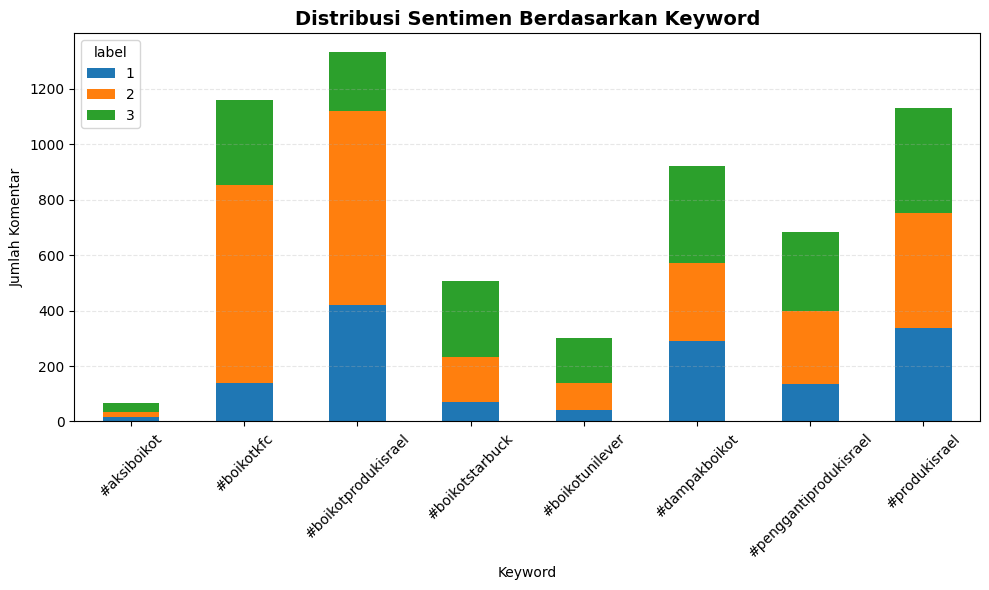

In [170]:
import matplotlib.pyplot as plt
import pandas as pd

# Crosstab keyword vs label
cross_tab = pd.crosstab(df_final['keyword'], df_final['label'])

# Pakai tab10 yang terang dan aman di mata
ax = cross_tab.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=plt.get_cmap('tab10').colors
)

plt.xticks(rotation=45)
plt.xlabel('Keyword')
plt.ylabel('Jumlah Komentar')
plt.title('Distribusi Sentimen Berdasarkan Keyword', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Berdasarkan grafik, keyword #aksiboikot, #boikotstarbuck, #boikotunilever, #dampakboikot dan #penggantiprodukisrael didominasi oleh komentar dengan sentimen negatif terhadap brand, yang berarti publik menunjukkan dukungan terhadap aksi boikot. Sementara itu, #boikotkfc, #boikotprodukisrael, dan #produkisrael didominasi oleh sentimen netral. Hal ini menunjukkan bahwa percakapan pada ketiga keyword tersebut cenderung bersifat informatif, mempertanyakan, atau belum secara tegas menunjukkan sikap mendukung maupun menolak boikot.

## Keyword Terpopuler Berdasarkan Jumlah Komentar

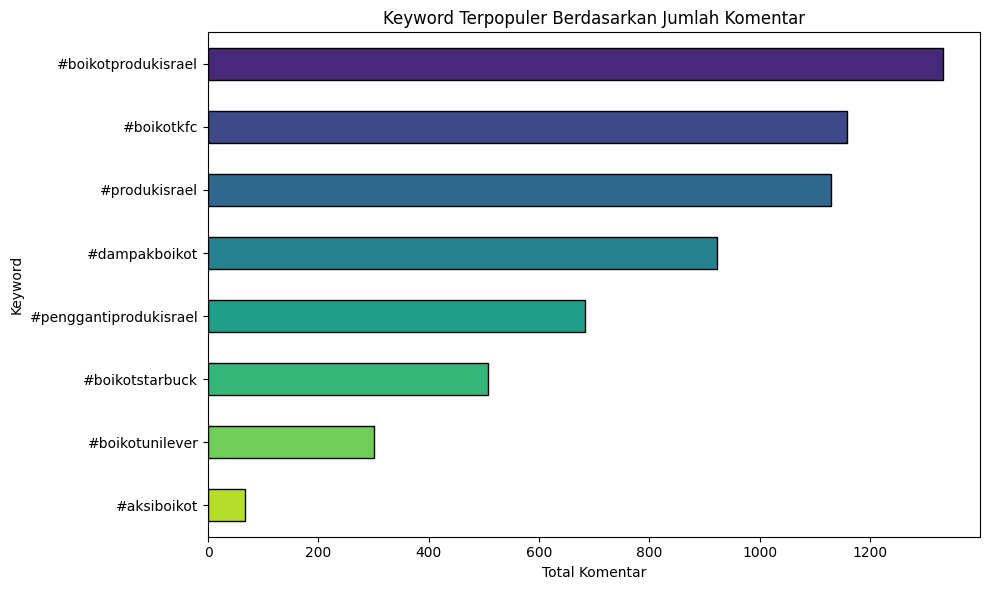

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung total komentar per keyword
total_per_keyword = cross_tab.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10, 6))

# Membuat gradasi warna viridis sesuai jumlah keyword
colors = sns.color_palette("viridis", len(total_per_keyword))

total_per_keyword.plot(
    kind='barh',
    color=colors,
    edgecolor='black'
)

plt.xlabel('Total Komentar')
plt.ylabel('Keyword')
plt.title('Keyword Terpopuler Berdasarkan Jumlah Komentar')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Grafik ini menunjukkan bahwa keyword #boikotprodukisrael, #boikotkfc, #produkisrael memiliki jumlah keyword terbanyak. Hal ini menunjukkan bahwa ketiga keyword tersebut menjadi fokus utama dalam percakapan publik terkait aksi boikot, baik sebagai bentuk dukungan maupun diskusi seputar isu tersebut. Sementara itu, keyword seperti #dampakboikot, #penggantiprodukisrael, dan #boikotstarbuck berada di tingkat menengah, yang menunjukkan bahwa isu tersebut tetap relevan, namun tidak sebesar topik utama.
Adapun #boikotunilever dan #aksiboikot memiliki jumlah komentar paling sedikit, yang bisa terjadi karena hanya ramai dalam waktu yang singkat.

## Tren Komentar Bulanan

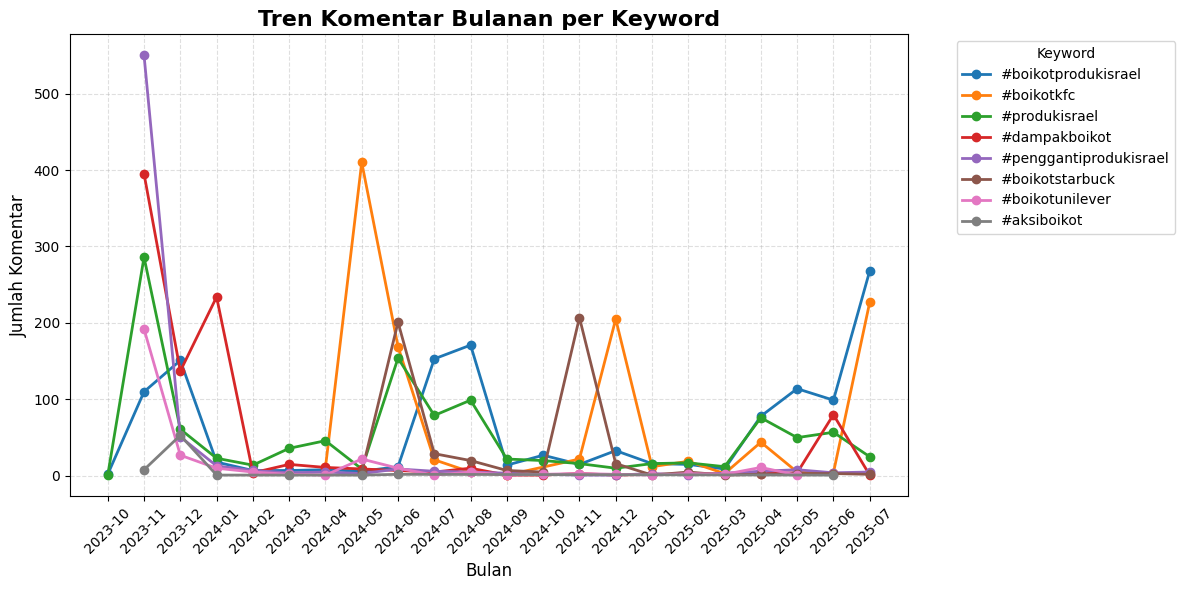

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ubah kolom waktu ke datetime, isi NaN dengan tanggal default
df_final['published_at'] = pd.to_datetime(df_final['published_at'], errors='coerce').fillna(pd.Timestamp('2000-01-01'))

# Buat kolom bulan
df_final['bulan'] = df_final['published_at'].dt.to_period('M').astype(str)

# Ambil 10 keyword teratas
top_keywords = df_final['keyword'].value_counts().head(10).index.tolist()

# Siapkan palet warna
palette = sns.color_palette("tab10", n_colors=len(top_keywords))

# Buat figure tunggal
plt.figure(figsize=(12, 6))

# Plot tiap keyword sebagai satu line berbeda
for idx, keyword in enumerate(top_keywords):
    keyword_data = (
        df_final[df_final['keyword'] == keyword]
        .groupby('bulan')
        .size()
        .sort_index()
    )
    plt.plot(keyword_data.index, keyword_data.values, label=keyword,
             color=palette[idx], marker='o', linewidth=2)

# Format plot
plt.title("Tren Komentar Bulanan per Keyword", fontsize=16, fontweight='bold')
plt.xlabel("Bulan", fontsize=12)
plt.ylabel("Jumlah Komentar", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title="Keyword", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Percakapan mengenai boikot mulai ramai sejak November–Desember 2023, seiring dengan munculnya isu serangan Israel ke Gaza. Beberapa keyword seperti #boikotprodukisrael, #produkisrael, dan #boikotkfc terus diperbincangkan hingga pertengahan 2025, menandakan bahwa isu ini bukan sekadar tren sesaat, melainkan tetap menarik perhatian publik dalam jangka waktu panjang. Sementara itu, keyword seperti #penggantiprodukisrael, #dampakboikot, #boikotunilever, dan #boikotstarbuck dan #aksiboikot hanya ramai di awal, kemudian menurun dan tidak lagi banyak dibahas. Pola ini menunjukkan bahwa sebagian besar isu cenderung bersifat musiman atau sekadar mengikuti momentum, namun ada juga isu yang tetap relevan dan konsisten muncul di percakapan publik.

## Jumlah Komentar negatif per keyword

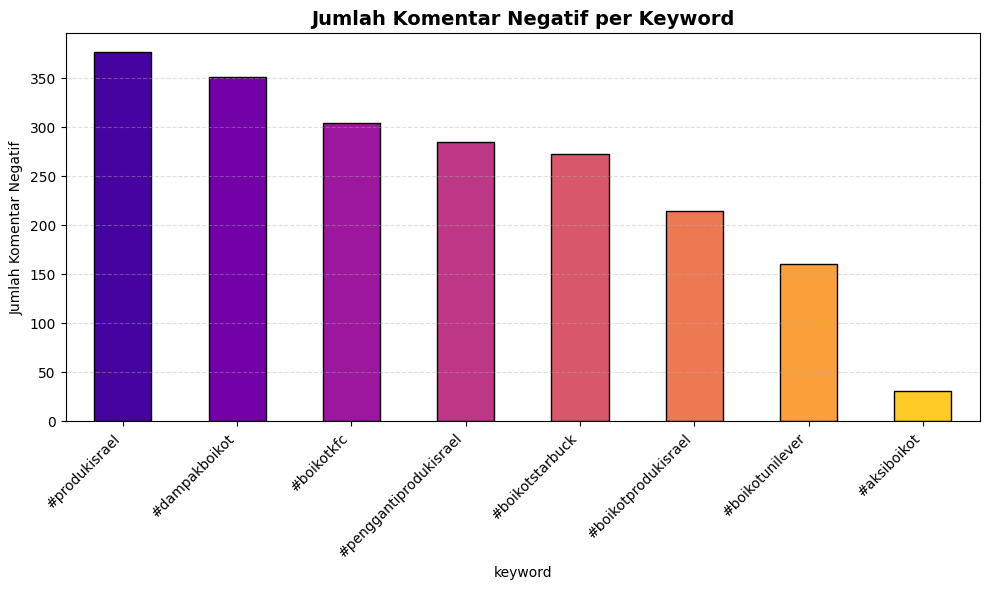

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data negatif
negatif = df_final[df_final['label'] == 3]
top_keywords = negatif['keyword'].value_counts().head(10)

plt.figure(figsize=(10, 6))

# Warna tegas yang konsisten, bukan gradasi lembut
colors = sns.color_palette("plasma", n_colors=len(top_keywords))

top_keywords.plot(
    kind='bar',
    color=colors,
    edgecolor='black'
)

plt.ylabel('Jumlah Komentar Negatif')
plt.title('Jumlah Komentar Negatif per Keyword', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Berdasarkan grafik, keyword #produkisrael memiliki jumlah komentar negatif tertinggi dibandingkan keyword lain, diikuti oleh #dampakboikot dan #boikotkfc. Meskipun pada analisis sebelumnya #produkisrael dan #boikotkfc didominasi oleh sentimen netral, jumlah komentar negatifnya tetap yang paling besar. Hal ini menunjukkan #produkisrael dan #boikotkfc menjadi topik yang paling banyak menarik perhatian publik, baik dari yang bersikap netral maupun yang aktif menunjukkan sikap negatif (mendukung boikot).

##Durasi waktu percakapan setiap keyword

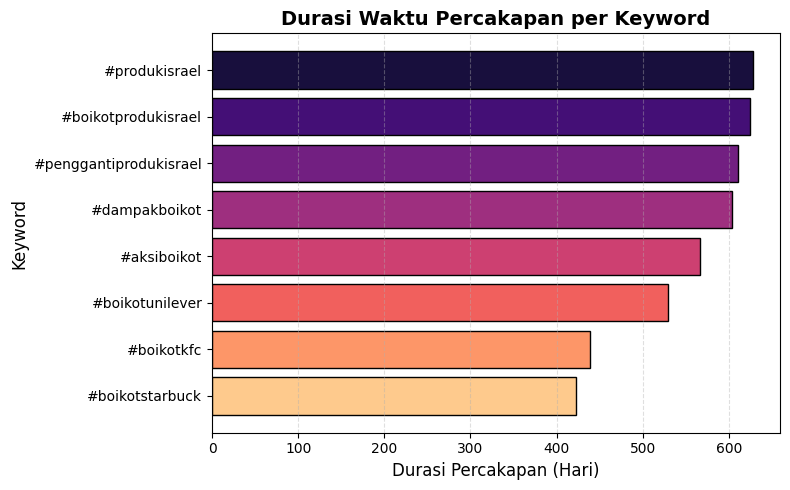

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_final['published_at'] = pd.to_datetime(df_final['published_at'], errors='coerce')
top_10_keywords = df_final['keyword'].value_counts().head(10).index.tolist()

durasi = df_final.groupby('keyword')['published_at'].agg(['min', 'max'])
durasi['lama_hari'] = (durasi['max'] - durasi['min']).dt.days

top_durasi = durasi.loc[top_10_keywords].sort_values('lama_hari', ascending=False)

# Pakai gradasi magma
colors = sns.color_palette("magma", n_colors=len(top_durasi))

plt.figure(figsize=(8, 5))
plt.barh(
    top_durasi.index,
    top_durasi['lama_hari'],
    color=colors,
    edgecolor='black'
)

plt.xlabel('Durasi Percakapan (Hari)', fontsize=12)
plt.ylabel('Keyword', fontsize=12)
plt.title('Durasi Waktu Percakapan per Keyword', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Grafik menunjukkan bahwa percakapan terkait keyword #produkisrael, #boikotprodukisrael, dan #penggantiprodukisrael memiliki durasi percakapan paling lama. Ini mengindikasikan bahwa isu terkait produk Israel konsisten menjadi perhatian publik dalam jangka waktu yang lama. Sementara itu, keyword seperti #boikotkfc dan #boikotstarbuck memiliki durasi percakapan yang lebih pendek, menunjukkan isu tersebut cenderung bersifat musiman atau hanya ramai saat momen-momen tertentu.

## Tren Percakapan Bulanan

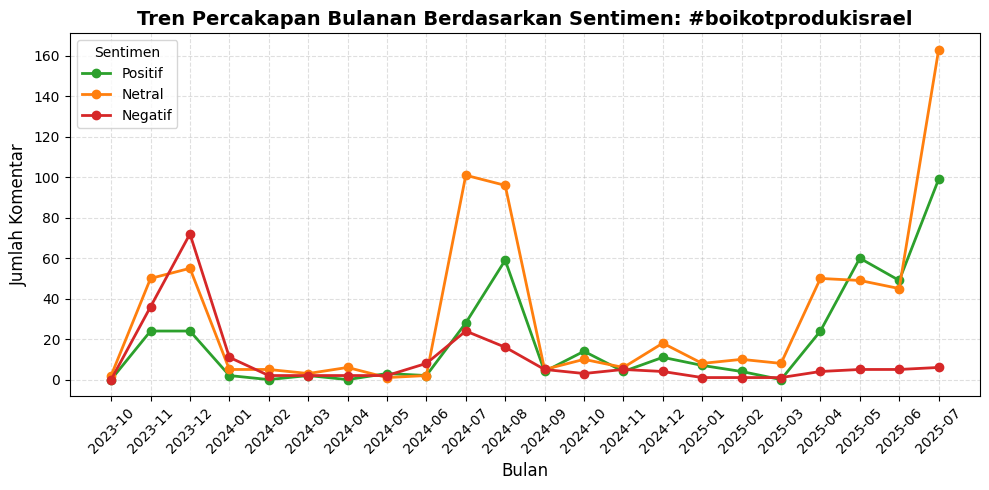

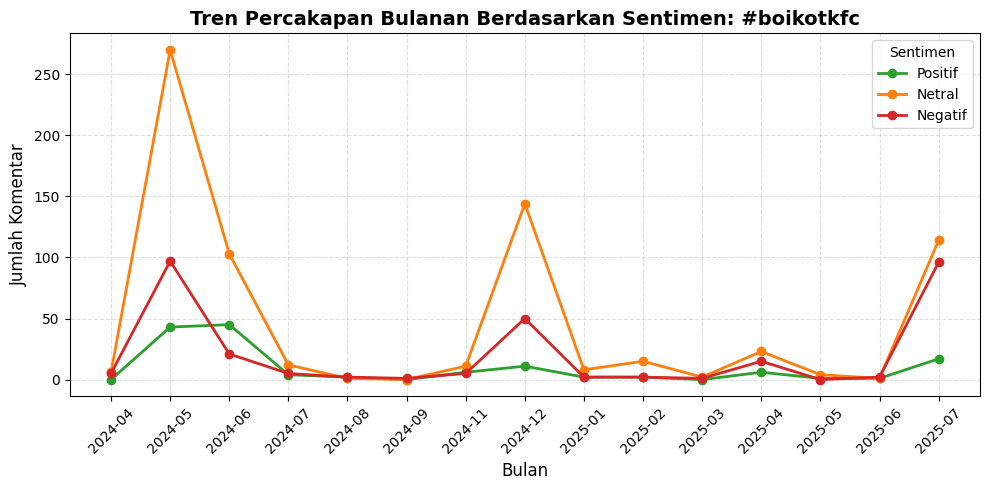

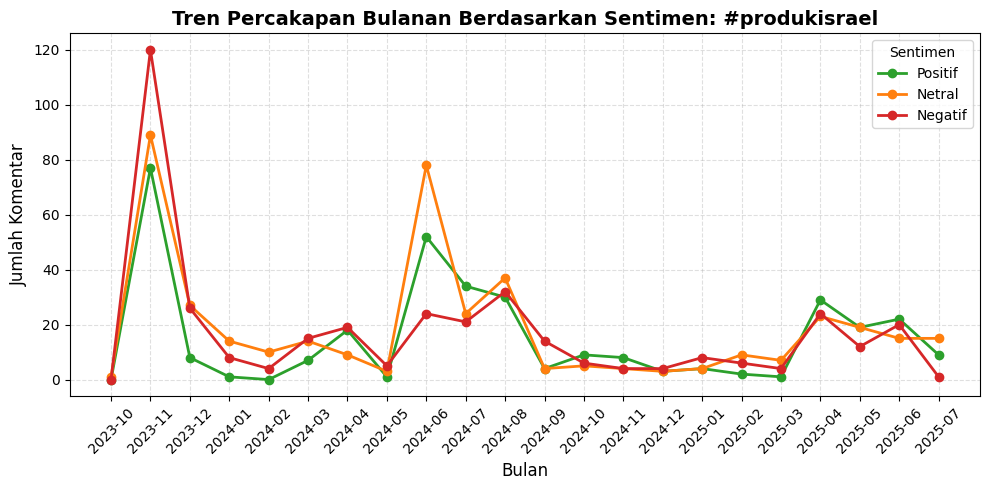

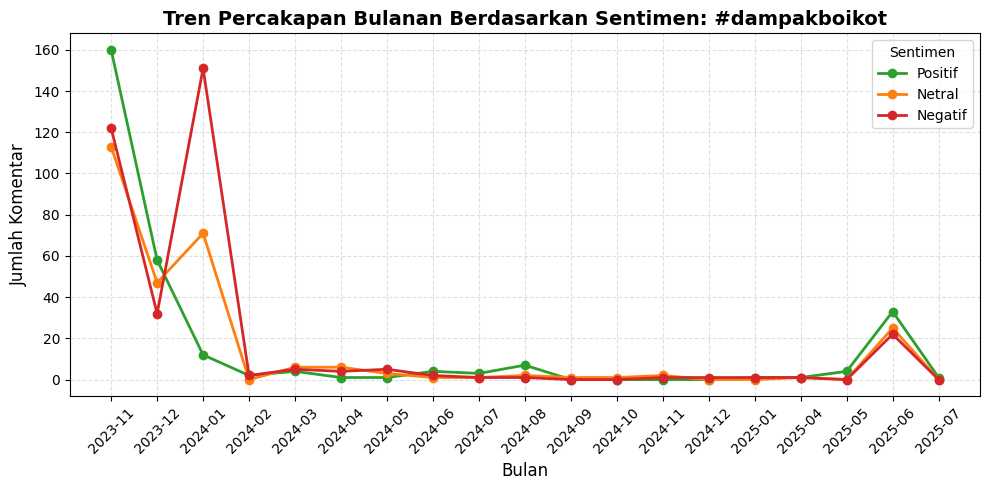

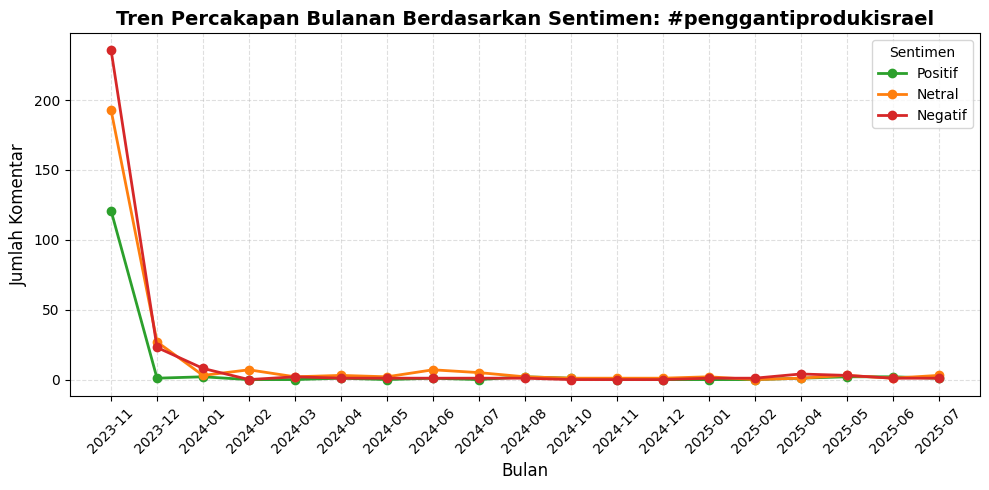

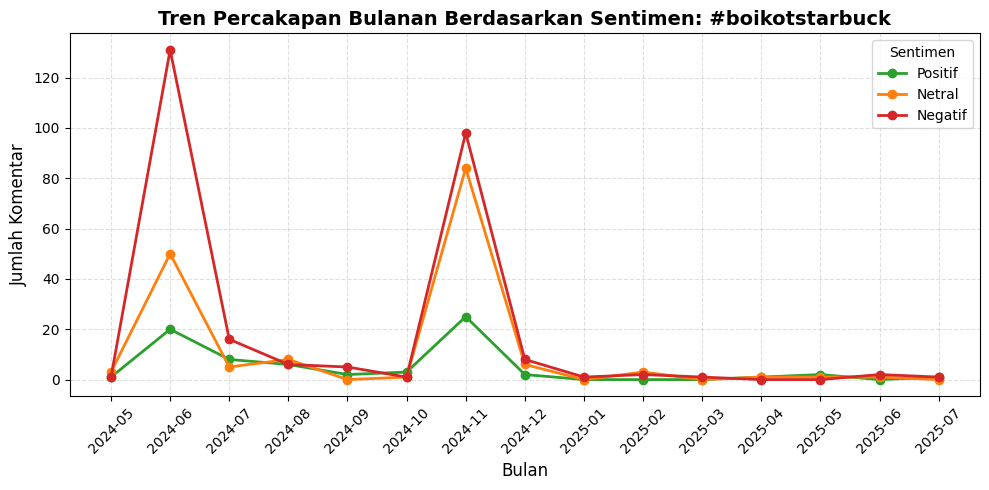

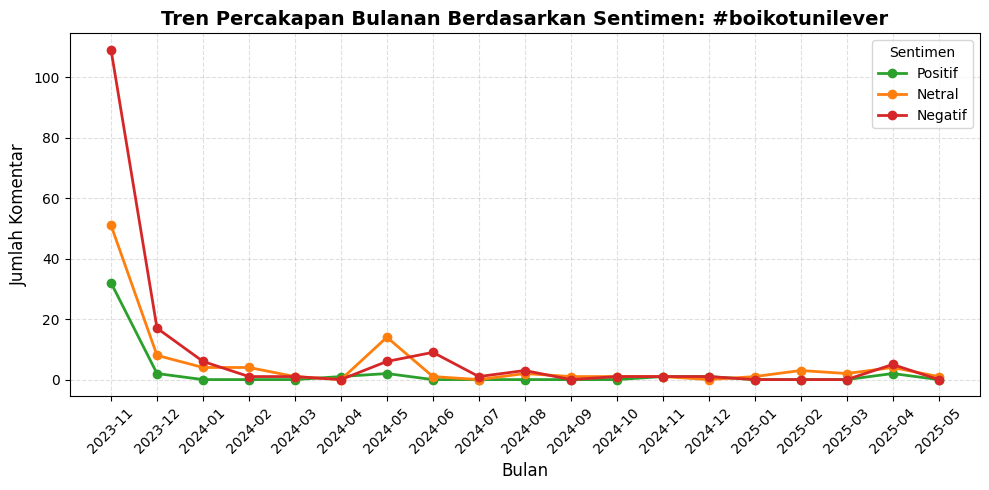

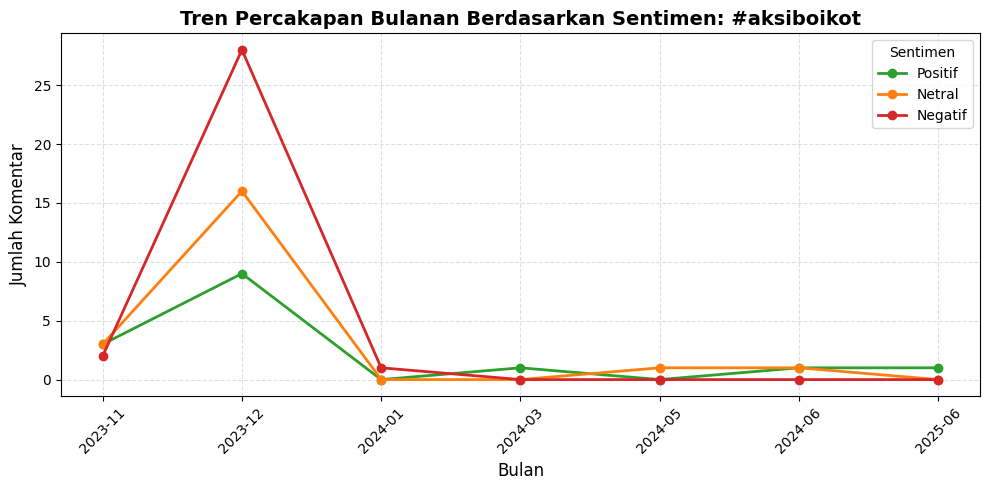

In [175]:
import pandas as pd
import matplotlib.pyplot as plt

# Pastikan kolom datetime dan bulan
df_final['published_at'] = pd.to_datetime(df_final['published_at'])
df_final['bulan'] = df_final['published_at'].dt.to_period('M').astype(str)

# Ambil 10 keyword terbanyak
top_keywords = df_final['keyword'].value_counts().head(10).index.tolist()

# Warna kontras dan konsisten
sentiment_colors = {
    1: '#2ca02c',  # Hijau (Positif)
    2: '#ff7f0e',  # Oranye (Netral)
    3: '#d62728'   # Merah (Negatif)
}

# Label sentimen mapping
label_map = {1: 'Positif', 2: 'Netral', 3: 'Negatif'}

# Visualisasi per keyword
for keyword in top_keywords:
    keyword_df = df_final[df_final['keyword'] == keyword]
    monthly_sentiment = keyword_df.groupby(['bulan', 'label']).size().unstack(fill_value=0)

    plt.figure(figsize=(10, 5))
    for label in sorted(monthly_sentiment.columns):
        plt.plot(
            monthly_sentiment.index,
            monthly_sentiment[label],
            marker='o',
            linewidth=2,
            label=label_map[label],
            color=sentiment_colors[label]
        )

    plt.title(f"Tren Percakapan Bulanan Berdasarkan Sentimen: {keyword}", fontsize=14, fontweight='bold')
    plt.xlabel("Bulan", fontsize=12)
    plt.ylabel("Jumlah Komentar", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title="Sentimen", fontsize=10)
    plt.tight_layout()
    plt.show()


Beberapa keyword mengalami lonjakan pada November dan Desember 2023, umumnya didominasi oleh sentimen negatif (mendukung boikot), sebagai respons terhadap serangan Israel ke Gaza yang memicu aksi boikot terhadap berbagai merek dan produk. Tagar seperti #boikotunilever dan #boikotstarbuck menunjukkan lonjakan sentimen negatif yang berulang, menandakan bahwa isu boikot terhadap merek tersebut memicu emosi publik di waktu tertentu. Di sisi lain, beberapa tagar seperti #produkisrael, #boikotkfc, dan #boikotprodukisrael menunjukkan lonjakan sentimen netral yang cukup tinggi pada periode tertentu. Ini mengindikasikan bahwa sebagian percakapan publik bersifat informatif atau tidak berpihak secara emosional. Sementara itu, pada tagar #dampakboikot, sentimen positif justru mencapai puncaknya pada November 2023, yang mengindikasikan adanya opini yang menilai boikot tidak berdampak signifikan atau tetap memilih menggunakan produk yang diboikot.


# Analisis Sentimen

## Pie chart sentimen

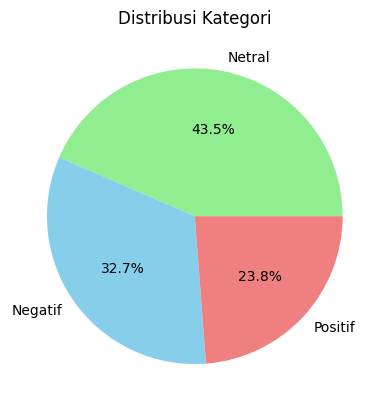

In [176]:
import matplotlib.pyplot as plt

# Menghitung distribusi kategori
category_counts = data['sentiment_label'].value_counts()

# Membuat pie chart
category_counts.plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'skyblue', 'lightcoral'])

# Menambahkan judul
plt.title('Distribusi Kategori')

# Menampilkan chart
plt.ylabel('')  # Menghilangkan label y agar lebih rapi
plt.show()

Interpretasi
Netral (43.5%) :
- Mayoritas komentar berisi opini dan pertanyaan apakah suatu produk juga harus diboikot. Selain itu, kritik untuk para penyeru aksi boikot juga banyak ditemukan.
- Netralitas muncul karena kebingungan netizen terhadap kebenaran informasi terkait aksi boikot produk.  

Negatif (32.7%) :
- Banyak ditemukan komentar mendukung aksi boikot sebagai bentuk solidaritas terhadap isu kemanusiaan.
- Netizen juga menunjukkan semangat untuk berpindah ke produk lokal dan mendukung UMKM sebagai bentuk aksi nyata.

Positif (23.8%) :
- Komentar cenderung meragukan efektivitas boikot, serta kekhawatiran bahwa boikot justru dapat merugikan pelaku UMKM lokal.
- Terdapat juga sebagian komentar sindiran atau sarkasme yang menyebut aksi boikot sebagai tindakan yang tidak konsisten atau hanya ikut-ikutan.

## Sentimen Positif

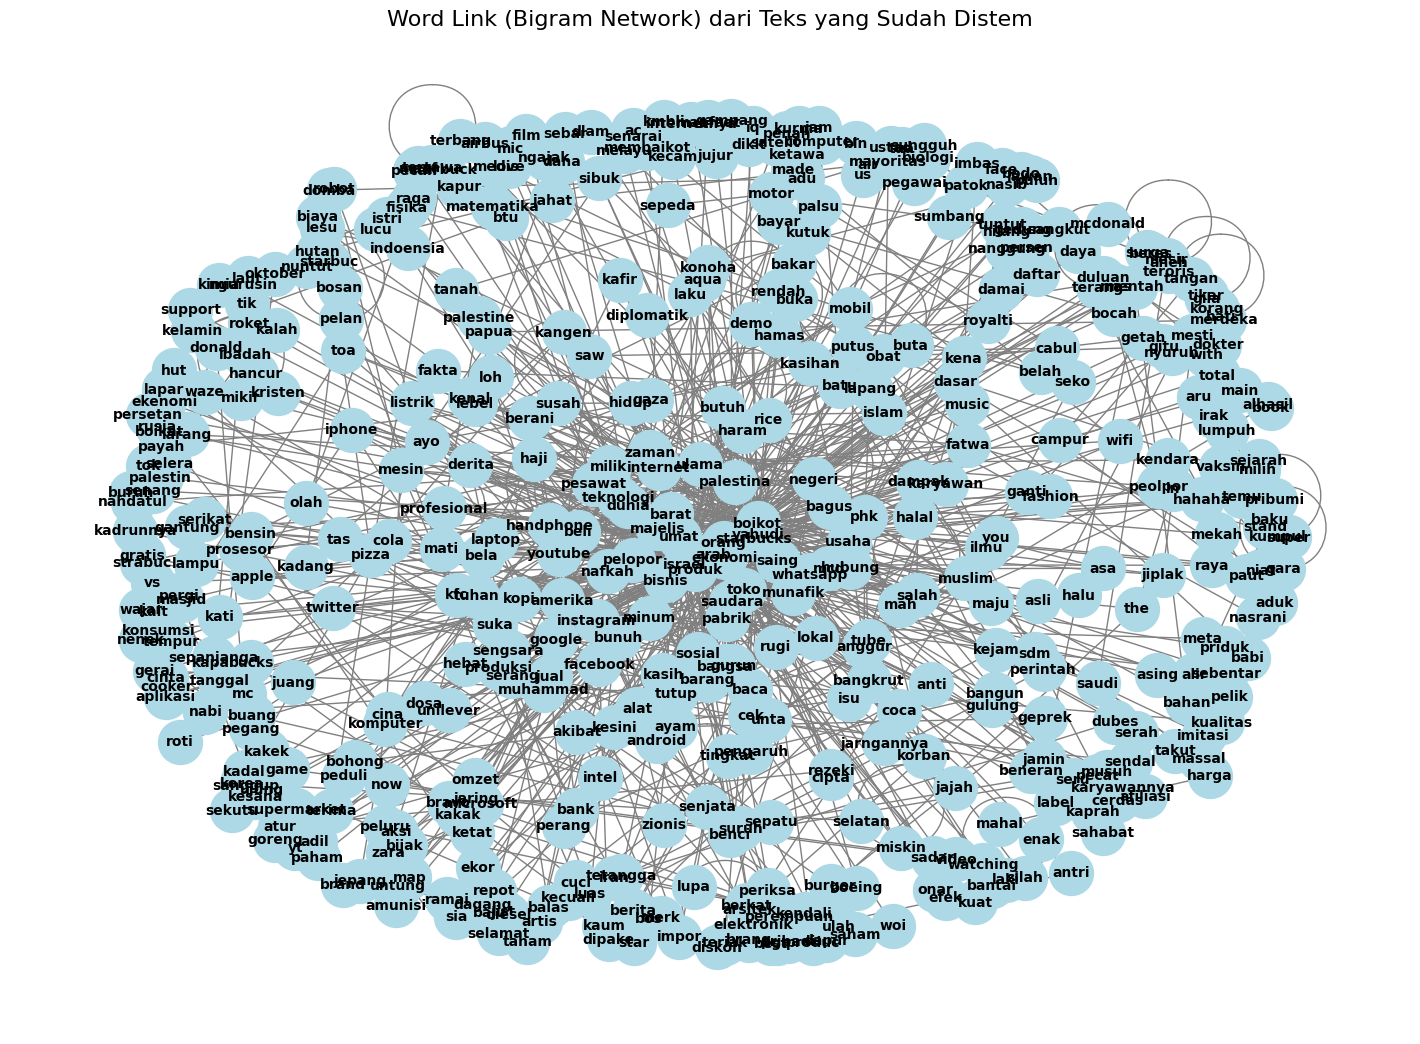

In [177]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import matplotlib.pyplot as plt

# Pastikan df_stemmed memiliki kolom 'text'
# Ambil daftar teks (kalimat) dan ubah ke lowercase
texts = data[data['label'] == 1]['no_stopwords2'].astype(str).str.lower().tolist()

# Gunakan CountVectorizer untuk ekstraksi bigram
vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=2)  # hanya bigram yang muncul minimal 2x
X = vectorizer.fit_transform(texts)
bigrams = vectorizer.get_feature_names_out()

# Pisahkan setiap bigram menjadi pasangan kata
edges = [tuple(b.split()) for b in bigrams]

# Buat Graph dari bigram
G = nx.Graph()
G.add_edges_from(edges)

# Visualisasi graf bigram
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)  # layout posisi node
nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightblue',
    edge_color='gray',
    node_size=1000,
    font_size=10,
    font_weight='bold'
)
plt.title("Word Link (Bigram Network) dari Teks yang Sudah Distem", fontsize=16)
plt.show()

 Network ini menunjukkan bahwa percakapan netizen mengenai penggunaan produk terboikot mencakup berbagai topik: dukungan terhadap palestina, senteimen terhadap boikot, narasi ekonomi dan nasionalisme. Kata-kata yang saling terhubung menegaskan adanya dua kutub persepsi utama: setuju  karena alasan rasa kemanusiaan, dan tidak setuju karena dikhawatirkan merugikan negara.



In [178]:
# Cek kata apa yang paling banyak punya edge (koneksi).
import networkx as nx

centrality = nx.degree_centrality(G)
sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]

[('israel', 0.26734693877551025),
 ('boikot', 0.25918367346938775),
 ('orang', 0.15306122448979592),
 ('produk', 0.1285714285714286),
 ('dunia', 0.05714285714285715),
 ('palestina', 0.05510204081632654),
 ('handphone', 0.05510204081632654),
 ('beli', 0.04285714285714286),
 ('phk', 0.04081632653061225),
 ('kfc', 0.04081632653061225)]

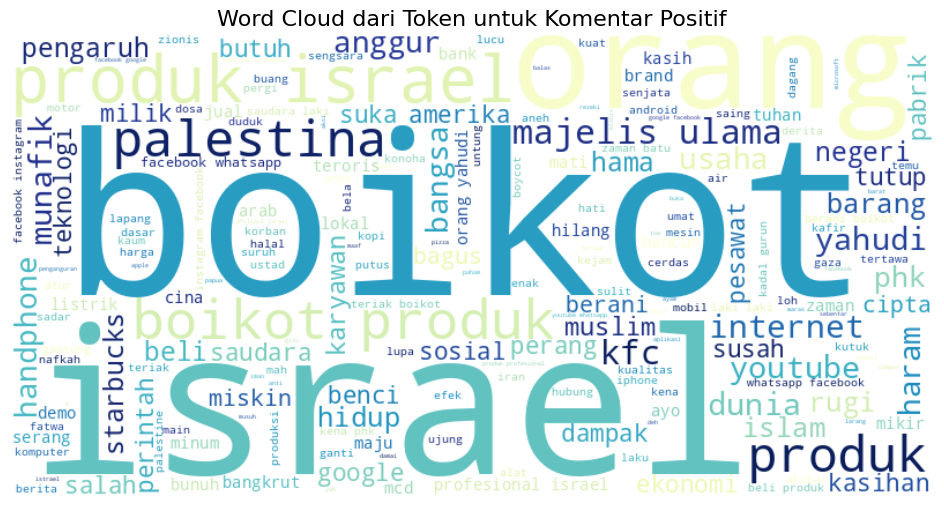

In [179]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter data ke label positif
positif_data = data[data['label'] == 1]

# Gabungkan semua token menjadi satu list
all_tokens = positif_data['tokenize_text'].sum()  # karena isinya list per baris

# Ubah list token menjadi string dipisahkan spasi
text_positif = " ".join(all_tokens)

# Buat Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    colormap='YlGnBu'
).generate(text_positif)

# Tampilkan
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud dari Token untuk Komentar Positif", fontsize=16)
plt.show()

Kata “boikot” dan “israel” tetap muncul besar, tapi konteksnya bukan mendukung aksi boikot melainkan menyindir orang yang boikot.

Kata “munafik”, “phk”, “usaha”, “pekerja”, “ekonomi”, “hidup”, “karyawan”
menunjukkan kekhawatiran atau sindiran bahwa boikot justru merugikan ekonomi ekonomi dan tenaga kerja Indonesia yang berpotensi adanya pemutusan hubungan kerja (PHK).

Kata “starbucks”, “kfc”, “unilever”, “youtube”, “google”
menunjukan sarkasme pada kontradiksi dimana netizen teriak boikot tapi tetap pakai produk buatan mereka.



## Sentimen Negatif

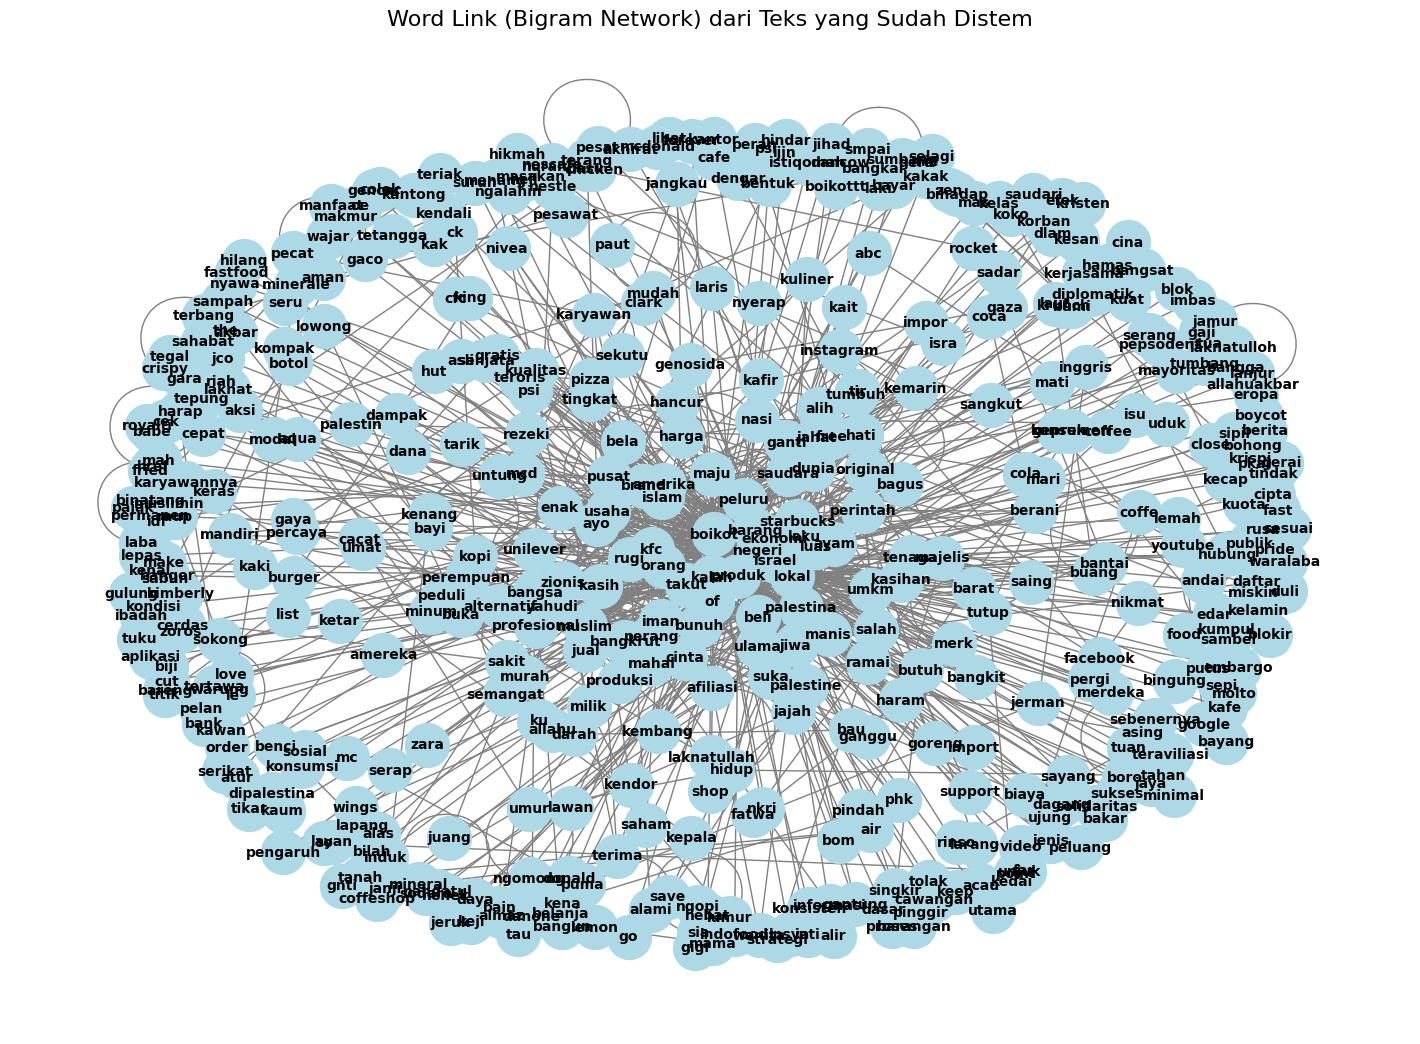

In [180]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import matplotlib.pyplot as plt

# Pastikan df_stemmed memiliki kolom 'text'
# Ambil daftar teks (kalimat) dan ubah ke lowercase
texts = data[data['label'] == 3]['no_stopwords2'].astype(str).str.lower().tolist()

# Gunakan CountVectorizer untuk ekstraksi bigram
vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=2)  # hanya bigram yang muncul minimal 2x
X = vectorizer.fit_transform(texts)
bigrams = vectorizer.get_feature_names_out()

# Pisahkan setiap bigram menjadi pasangan kata
edges = [tuple(b.split()) for b in bigrams]

# Buat Graph dari bigram
G = nx.Graph()
G.add_edges_from(edges)

# Visualisasi graf bigram
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)  # layout posisi node
nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightblue',
    edge_color='gray',
    node_size=1000,
    font_size=10,
    font_weight='bold'
)
plt.title("Word Link (Bigram Network) dari Teks yang Sudah Distem", fontsize=16)
plt.show()

Diagram  ini menunjukkan bahwa percakapan netizen sentimen negatif (tidak setuju terhadap penggunaan produk terboikot) mengenai penggunaan produk terboikot mencakup berbagai topik: ajakan untuk mengganti produk, penolakan terhadap produk, kritik sosial dan ekonomi. Kata-kata yang saling terhubung menegaskan adanya dua kutub persepsi utama: setuju  karena alasan rasa kemanusiaan, dan tidak setuju karena dikhawatirkan merugikan negara.



In [181]:
# Cek kata apa yang paling banyak punya edge (koneksi).
import networkx as nx

centrality = nx.degree_centrality(G)
sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]

[('produk', 0.2765957446808511),
 ('boikot', 0.24042553191489363),
 ('israel', 0.2148936170212766),
 ('beli', 0.1021276595744681),
 ('lokal', 0.08297872340425531),
 ('orang', 0.07021276595744681),
 ('palestina', 0.07021276595744681),
 ('kfc', 0.06595744680851064),
 ('usaha', 0.055319148936170216),
 ('negeri', 0.05319148936170213)]

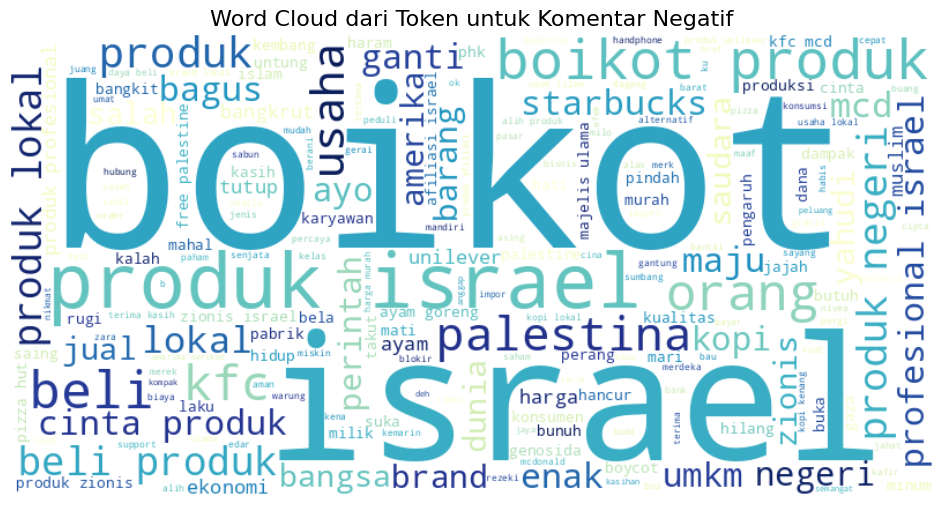

In [182]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter data ke label positif
positif_data = data[data['label'] == 3]

# Gabungkan semua token menjadi satu list
all_tokens = positif_data['tokenize_text'].sum()  # karena isinya list per baris

# Ubah list token menjadi string dipisahkan spasi
text_positif = " ".join(all_tokens)

# Buat Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    colormap='YlGnBu'
).generate(text_positif)

# Tampilkan
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud dari Token untuk Komentar Negatif", fontsize=16)
plt.show()

Dari word cloud komentar negatif, terlihat kata-kata dominan seperti boikot, Produk Israel, kfc, unilever dan Starbucks. Ini menunjukkan ketidakinginan netizen untuk membeli brand yang dianggap terafiliasi dengan israel.

Disisi lain muncul juga kata UMKM, produk lokal, ganti, saing, enak, harga dan murah menunjukkan bahwa alasan konsumen berpindah ke produk lokal bukan hanya soal ketidakterikatan brand terhadap isu palestina tetapi juga mengenai harga dan kualitas.

## Sentimen Netral

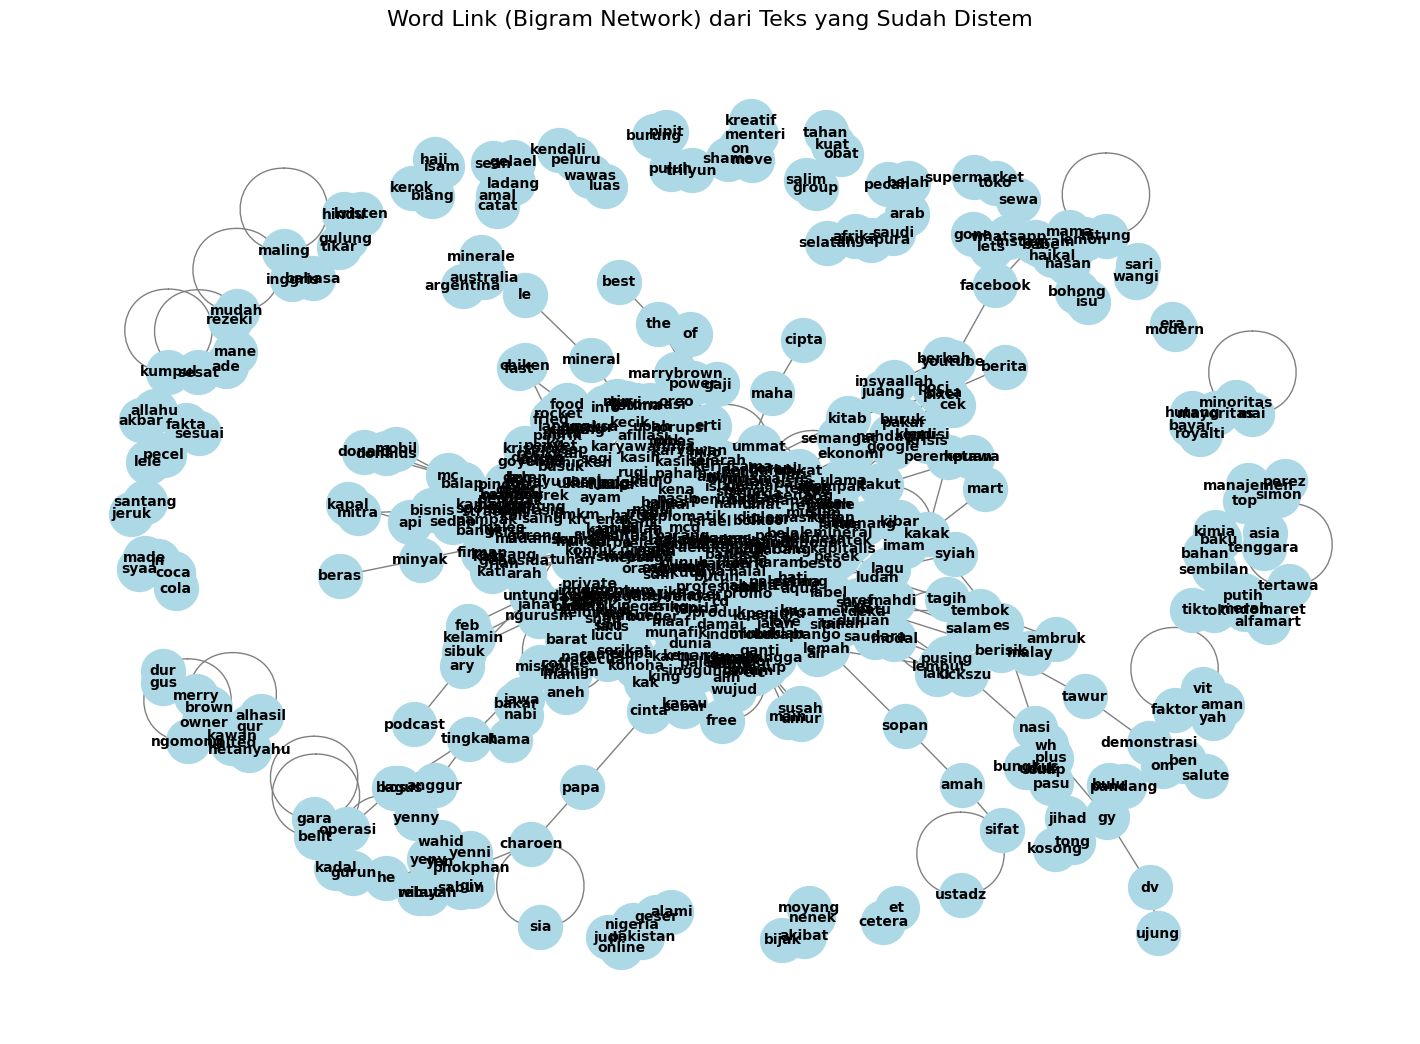

In [183]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import matplotlib.pyplot as plt

# Pastikan df_stemmed memiliki kolom 'text'
# Ambil daftar teks (kalimat) dan ubah ke lowercase
texts = data[data['label'] == 2]['no_stopwords2'].astype(str).str.lower().tolist()

# Gunakan CountVectorizer untuk ekstraksi bigram
vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=2)  # hanya bigram yang muncul minimal 2x
X = vectorizer.fit_transform(texts)
bigrams = vectorizer.get_feature_names_out()

# Pisahkan setiap bigram menjadi pasangan kata
edges = [tuple(b.split()) for b in bigrams]

# Buat Graph dari bigram
G = nx.Graph()
G.add_edges_from(edges)

# Visualisasi graf bigram
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)  # layout posisi node
nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightblue',
    edge_color='gray',
    node_size=1000,
    font_size=10,
    font_weight='bold'
)
plt.title("Word Link (Bigram Network) dari Teks yang Sudah Distem", fontsize=16)
plt.show()

Karena pada wordlink sentimen netral ini sulit diintrepetasikan pada topik terkait penggunaan produk terboikot (tidak terlalu bermakna secara analitis). Maka dilakukan analisis lanjutan untuk sentimen netral.

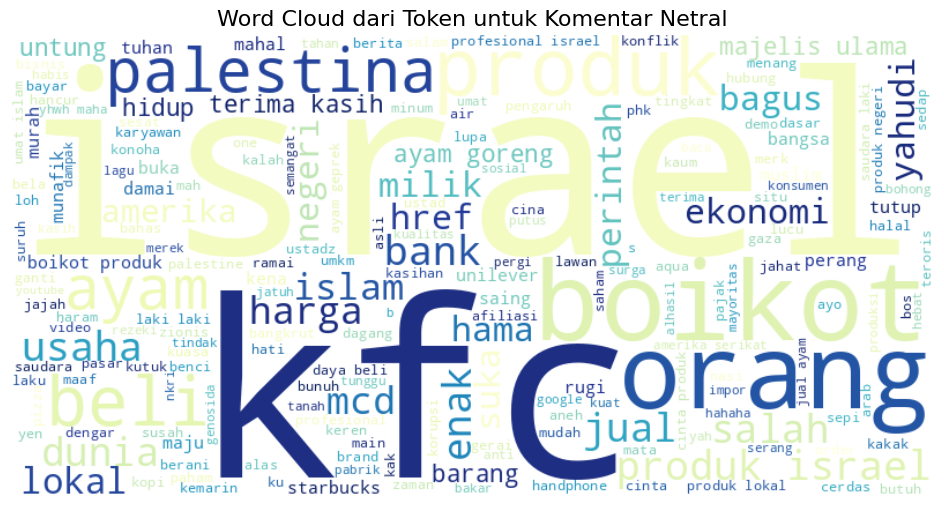

In [184]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter data ke label positif
positif_data = data[data['label'] == 2]

# Gabungkan semua token menjadi satu list
all_tokens = positif_data['tokenize_text'].sum()  # karena isinya list per baris

# Ubah list token menjadi string dipisahkan spasi
text_positif = " ".join(all_tokens)

# Buat Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    colormap='YlGnBu'
).generate(text_positif)

# Tampilkan
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud dari Token untuk Komentar Netral", fontsize=16)
plt.show()

Dari word cloud komentar netral, terlihat kemunculan kata-kata seperti “produk”, “harga”, “boikot”, “pengganti”, dan “lokal”. Ini menunjukkan bahwa netizen hanya berdiskusi terkait perbandingan harga produk yang termasuk list boikot dengan produk lokal tanpa menganjurkan untuk memboikot ataupun mendukung produk yang diboikot.

## Analisis Lebih Lanjut Sentimen Netral


In [185]:
# Misal kolom sentimen bernama 'label'
netral_data = data[data['label'] == 2]
print(f"Total komentar netral: {len(netral_data)}")

Total komentar netral: 2653


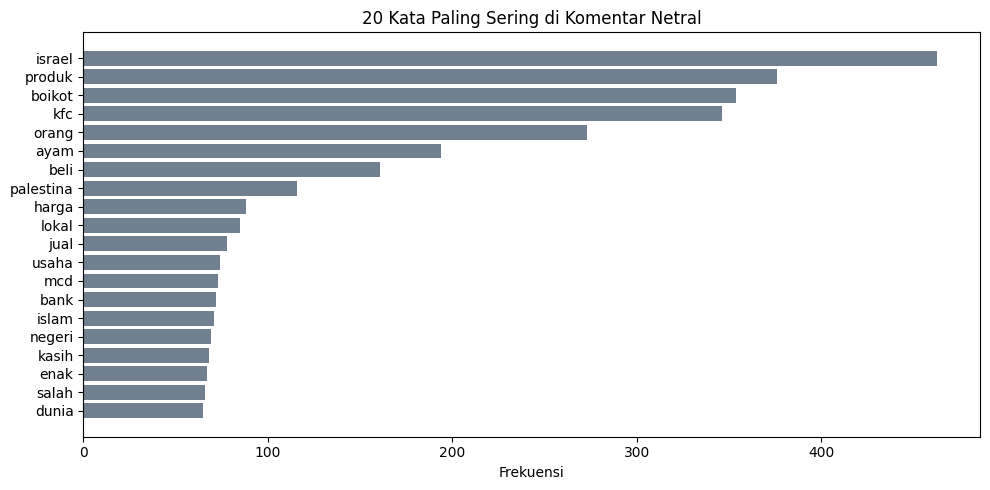

In [186]:
from collections import Counter

# Gabungkan semua teks komentar netral
all_text = ' '.join(netral_data['no_stopwords2'])

# Pecah jadi kata
words = all_text.split()
word_freq = Counter(words).most_common(20)

# Visualisasi
import matplotlib.pyplot as plt
words, freqs = zip(*word_freq)
plt.figure(figsize=(10,5))
plt.barh(words[::-1], freqs[::-1], color='slategray')
plt.title('20 Kata Paling Sering di Komentar Netral')
plt.xlabel('Frekuensi')
plt.tight_layout()
plt.show()

* Komentar netral cenderung menggambarkan kebingungan, pencarian informasi, dan diskusi terbuka. Kata-kata seperti "israel", "produk", dan "boikot" menunjukkan bahwa netizen sedang membicarakan atau mempertanyakan hubungan antara merek tertentu (misalnya KFC, MCD, Bank) dengan isu geopolitik.

* Kata "ayam", "beli", "harga", dan "enak" mengindikasikan adanya fokus pada aspek produk secara langsung, seperti kualitas makanan atau harga jual. Sementara itu, kata "lokal", "usaha", dan "negeri" mencerminkan munculnya diskusi tentang alternatif produk dalam negeri atau UMKM.

* Beberapa komentar juga menunjukkan sikap mempertanyakan atau mencari klarifikasi, terlihat dari kata-kata seperti "dimana", "salah", dan "kasih".

In [187]:
# Hitung total komentar per video
total_per_video = data['video_title'].value_counts().reset_index(name='total_komentar')
total_per_video.columns = ['video_title', 'total_komentar']

# Hitung komentar netral per video
netral_per_video = netral_data['video_title'].value_counts().reset_index(name='komentar_netral')
netral_per_video.columns = ['video_title', 'komentar_netral']

# Gabungkan berdasarkan video_title
summary = pd.merge(netral_per_video, total_per_video, on='video_title')

# Hitung rasio komentar netral
summary['rasio_netral'] = summary['komentar_netral'] / summary['total_komentar']

# Tampilkan top 10 video dengan rasio netral tertinggi
summary.sort_values('rasio_netral', ascending=False).head(10)

video_title  komentar_netral  \
55  Apa Dampak Boikot Produk Israel Bagi Pebisnis ...                1   
53  Aksi Boikot Gak Berhasil? Ini Faktanya  | POPL...                1   
48  CEO Starbucks Ungkap Boikot Berdampak Signifik...                2   
56  RUSIA AJUKAN SOLUSI ATAS KETEGANGAN NUKLIR IRA...                1   
9                   KFC TUTUP BUKAN DISEBABKAN BOIKOT               95   
35  Saham Unilever hari ini terpuruk bukan karena ...               15   
40  DAFTAR MEREK LOKAL PENGGANTI PRODUK PRO ISRAEL...                8   
0   MISTERI DIBALIK TUTUPNYA 47 GERAI KFC DI INDON...              179   
21                Israel, Palestina dan BOIKOT PRODUK               57   
30  Gara-gara Israel, 100 Gerai KFC di Malaysia Ba...               20   

    total_komentar  rasio_netral  
55               1      1.000000  
53               1      1.000000  
48               2      1.000000  
56               1      1.000000  
9              126      0.753968  
35              20      0.750000  
40              11      0.727273  
0              250      0.716000  
21              81      0.703704  
30              30      0.666667

Beberapa video yang didominasi oleh  oleh komentar netral atau dengan rasio netral tinggi menunjukkan bahwa warganet masih mencari kejelasan tentang keterkaitan suatu produk dengan konflik yang sedang berlangsung. Selain itu, ada kemungkinan informasi dari video memicu netizen untuk berdiskusi diskusi, bukan sekadar adu opini.

# Topik Modelling

In [188]:
!pip install bertopic

In [189]:
from bertopic import BERTopic

## Sentimen Positif

In [190]:
text_pos = data[data['label'] == 1]
texts = text_pos['no_stopwords2']
texts

18                         israel produk starbucks a href
19            boikot hamas palestina teroris loh awokawok
20                                    israel hidup israel
24      starbucks enak murah muslim boikot starbucks o...
39                               menu kopi starbukcs enak
                              ...                        
6109    gerai dampak hilang miliar miliar putar miliar...
6110    pengaruh israel israel kfc starbucks mcdonald ...
6113                                  kasihan karyawannya
6119    kfc tutup tiada kesan israel rafah serang sia ...
6130                              boikot facebook youtube
Name: no_stopwords2, Length: 1452, dtype: object

In [191]:
texts = texts.astype(str).tolist()

In [192]:
# Install UMAP if not already installed
!pip install umap-learn
!pip install hdbscan # Install hdbscan library

# Import UMAP
from umap import UMAP
from hdbscan import HDBSCAN # Import HDBSCAN

In [193]:
# Inisialisasi model UMAP dengan random_state
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=37)

# Inisialisasi model clustering HDBSCAN dengan random_state
hdbscan_model = HDBSCAN(min_cluster_size=10,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

# Inisialisasi BERTopic dengan model yang sudah disetel random_state
topic_model = BERTopic(
    language="indonesian",
    calculate_probabilities=True,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)

# Fit model
topics, probs = topic_model.fit_transform(texts)

# Tampilkan topik dominan
topic_model.get_topic_info()

2025-07-17 17:38:25,308 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

2025-07-17 17:39:11,553 - BERTopic - Embedding - Completed ✓
2025-07-17 17:39:11,556 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-17 17:39:17,972 - BERTopic - Dimensionality - Completed ✓
2025-07-17 17:39:17,973 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-17 17:39:18,112 - BERTopic - Cluster - Completed ✓
2025-07-17 17:39:18,117 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-17 17:39:18,170 - BERTopic - Representation - Completed ✓


Topic  Count                                    Name  \
0      -1    309            -1_dunia_orang_boikot_produk   
1       0    190          0_palestina_israel_hamas_papua   
2       1    172            1_israel_boikot_produk_orang   
3       2     72                2_obral_pendek_pura_moto   
4       3     70                3_kfc_boikot_islam_orang   
5       4     55              4_produk_israel_bagus_beli   
6       5     48           5_internet_boikot_listrik_ngr   
7       6     47           6_boikot_pengaruh_jernih_efek   
8       7     38     7_youtube_facebook_instagram_boikot   
9       8     36      8_handphone_haram_pesawat_internet   
10      9     31              9_karyawan_phk_bisnis_sisi   
11     10     30    10_youtube_facebook_yahudi_instagram   
12     11     26     11_produk_kualitas_indoensia_import   
13     12     26                12_hidup_cocok_be_lantar   
14     13     26         13_handphone_buang_laptop_suruh   
15     14     26              14_majelis_ulama_iman_zara   
16     15     24            15_muslim_islam_mungkar_umat   
17     16     24                16_boikot_toa_gblok_tepi   
18     17     23  17_whatsapp_facebook_instagram_youtube   
19     18     21                   18_mcd_kfc_laa_boycot   
20     19     20         19_anggur_selamat_gaji_perintah   
21     20     17     20_whatsapp_facebook_instagram_baju   
22     21     17    21_whatsapp_facebook_instagram_konco   
23     22     16             22_iphone_apple_korang_sial   
24     23     15         23_starbucks_kopi_minum_blender   
25     24     14             24_bagamana_sukak_lou_mikir   
26     25     14             25_anggur_sukses_papa_jepit   
27     26     12           26_karyawan_pabrik_bos_boikot   
28     27     12             27_kfc_gerai_boikot_saudara   
29     28     11               28_miliar_ton_ekonomi_sia   
30     29     10              29_islam_kuli_muslim_fatwa   

                                       Representation  \
0   [dunia, orang, boikot, produk, israel, beli, l...   
1   [palestina, israel, hamas, papua, teroris, bel...   
2   [israel, boikot, produk, orang, palestina, mis...   
3   [obral, pendek, pura, moto, ah, perempuan, pen...   
4   [kfc, boikot, islam, orang, ulama, muslim, maj...   
5   [produk, israel, bagus, beli, barang, laki, ku...   
6   [internet, boikot, listrik, ngr, istrael, goog...   
7   [boikot, pengaruh, jernih, efek, orang, jglah,...   
8   [youtube, facebook, instagram, boikot, google,...   
9   [handphone, haram, pesawat, internet, yahudi, ...   
10  [karyawan, phk, bisnis, sisi, tutup, majelis, ...   
11  [youtube, facebook, yahudi, instagram, israel,...   
12  [produk, kualitas, indoensia, import, sebutin,...   
13  [hidup, cocok, be, lantar, planet, orang, dasa...   
14  [handphone, buang, laptop, suruh, mobil, konsi...   
15  [majelis, ulama, iman, zara, dosa, tuhan, kome...   
16  [muslim, islam, mungkar, umat, cegah, orang, s...   
17  [boikot, toa, gblok, tepi, larisss, dak, ngoce...   
18  [whatsapp, facebook, instagram, youtube, googl...   
19  [mcd, kfc, laa, boycot, list, boikot, bukber, ...   
20  [anggur, selamat, gaji, perintah, salah, phk, ...   
21  [whatsapp, facebook, instagram, baju, google, ...   
22  [whatsapp, facebook, instagram, konco, google,...   
23  [iphone, apple, korang, sial, kfc, dipake, mun...   
24  [starbucks, kopi, minum, blender, enak, brand,...   
25  [bagamana, sukak, lou, mikir, repot, jamin, gr...   
26  [anggur, sukses, papa, jepit, sandal, boikot, ...   
27  [karyawan, pabrik, bos, boikot, phk, pengaruh,...   
28  [kfc, gerai, boikot, saudara, ayaq, dpd, hipok...   
29  [miliar, ton, ekonomi, sia, rugi, hilang, dagi...   
30  [islam, kuli, muslim, fatwa, frodina, farah, g...   

                                  Representative_Docs  
0   [persen dunia orang israel orang barat jiplak ...  
1   [lepas handphone internet whatsapp facebook tw...  
2   [israel miskin kiamat boikot dunia israel heba...  
3   [mikirin mata papua merdeka ka

In [194]:
topic_model.visualize_topics()

In [195]:
topic_model.visualize_barchart(top_n_topics=3)

Topic modeling dilakukan pada komentar bersentimen positif dan menghasilkan 29 topik. Berikut adalah kumpulan 3 topik teratas yang sering muncul dalam sentimen positif.

- **Topik 0**: *Pembelaan terhadap produk dan konsumen*

 **Kata kunci**: boikot, kfc, orang, lokal, boycot

 **Interpretasi**: Netizen menanggapi isu boikot dengan menolak ikut serta karena merasa tindakan boikot berlebihan atau menyalahkan konsumen lokal. KFC dan produk lokal justru dianggap tidak bersalah.

- **Topik 1**: *Fokus pada profesionalisme dan pilihan individu*

 **Kata kunci**: israel, produk, profesional, beli, usaha

 **Interpretasi**: Pengguna menyampaikan bahwa membeli produk adalah keputusan rasional dan profesional, bukan urusan politik. Beberapa menyebut tetap membeli karena mendukung pelaku usaha, bukan negara tertentu.

- **Topik 2**: *Simpatik terhadap pelaku usaha lokal*

 **Kata kunci**: mudah, tikar, rezeki, gulung, jahat

 **Interpretasi**: Ada narasi bahwa boikot berdampak buruk terhadap rezeki pekerja kecil dan UMKM lokal yang bermitra dengan brand global. Boikot dianggap “jahat” dan tidak menyelesaikan masalah.






## Sentimen Negatif

In [196]:
text_pos2 = data[data['label'] == 3]
texts2 = text_pos2['no_stopwords2']
texts2

0                              starbucks lgbt mari boikot
1       starbucks kopi shop ken ngopi kopi shop biji k...
3       beli kopi peluru palestina inget kopi lokal en...
4       starbucks negeri warung kopi lokal jamur kalah...
5       starbucks mcd kfc jenis beli konsumen budak su...
                              ...                        
6141                           kfc tutup jual lokal ramai
6142                                            inodnesia
6149                            boikot restoran palestina
6150    orang berani boikot produk israel teriak sosia...
6151    tutup kfc mcd profesional produk lokal israel ...
Name: no_stopwords2, Length: 1997, dtype: object

In [197]:
texts2 = texts2.astype(str).tolist()

In [198]:
topic_model2 = BERTopic(language="indonesian", calculate_probabilities=True)  # gunakan bahasa Indonesia
topics, probs = topic_model2.fit_transform(texts2)

topic_model2.get_topic_info()

Topic  Count                                   Name  \
0      -1    244         -1_produk_israel_boikot_zionis   
1       0    445         0_israel_produk_palestina_beli   
2       1    367              1_boikot_kfc_boycot_lokal   
3       2    156               2_mudah_umkm_cepat_tikar   
4       3     84            3_produk_mahal_beli_bingung   
5       4     75            4_kopi_starbucks_enak_lokal   
6       5     63              5_lokal_produk_maju_brand   
7       6     63           6_muslim_islam_yahudi_boikot   
8       7     60           7_israel_produk_boikot_usaha   
9       8     57              8_boikot_abc_dfc_starlink   
10      9     51                 9_ayam_goreng_enak_kfc   
11     10     49          10_negeri_maju_produk_mandiri   
12     11     42  11_palestina_boikot_merdeka_palestine   
13     12     40      12_israel_boikot_terang_netanyahu   
14     13     30         13_israel_boikot_produk_nagara   
15     14     25                     14_mcd_mc_kfc_umkm   
16     15     24          15_negeri_cinta_produk_bangsa   
17     16     22              16_driver_lokal_you_order   
18     17     21       17_palestina_teroris_israel_free   
19     18     19       18_zionis_sekutu_boikottt_israel   
20     19     17           19_pizza_hut_restoran_domino   
21     20     17               20_puma_bala_zen_boikoot   
22     21     15         21_cinta_produk_saatny_sinergi   
23     22     11          22_amerika_of_internet_israel   

                                       Representation  \
0   [produk, israel, boikot, zionis, beli, profesi...   
1   [israel, produk, palestina, beli, profesional,...   
2   [boikot, kfc, boycot, lokal, orang, produk, be...   
3   [mudah, umkm, cepat, tikar, rezeki, orang, gul...   
4   [produk, mahal, beli, bingung, umkm, konsumen,...   
5   [kopi, starbucks, enak, lokal, minum, kenang, ...   
6   [lokal, produk, maju, brand, kualitas, go, mer...   
7   [muslim, islam, yahudi, boikot, majelis, ulama...   
8   [israel, produk, boikot, usaha, perintah, prof...   
9      [boikot, abc, dfc, starlink, isreal, , , , , ]   
10  [ayam, goreng, enak, kfc, nasi, chicken, gepre...   
11  [negeri, maju, produk, mandiri, bangsa, ekonom...   
12  [palestina, boikot, merdeka, palestine, nomor,...   
13  [israel, boikot, terang, netanyahu, undang, pe...   
14  [israel, boikot, produk, nagara, titikkkkk, gn...   
15  [mcd, mc, kfc, umkm, paket, jco, gaji, nenek, ...   
16  [negeri, cinta, produk, bangsa, sejahtera, hre...   
17  [driver, lokal, you, order, online, isr, antri...   
18  [palestina, teroris, israel, free, palestine, ...   
19  [zionis, sekutu, boikottt, israel, titik, ayo,...   
20  [pizza, hut, restoran, domino, bay, kfc, fast,...   
21  [puma, bala, zen, boikoot, he, pkai, min, boro...   
22  [cinta, produk, saatny, sinergi, ayoh, paut, b...   
23  [amerika, of, internet, israel, semangat, mili...   

                                  Representative_Docs  
0   [boikot produk zionis israel, boikot produk zi...  
1       [produk israel, produk israel, produk israel]  
2       [boikot boikot, boikot boikot, boikot boikot]  
3   [sebentar gulung tikar tunggu, terima kasih in...  
4   [produk, produk produk hemat produk produk mur...  
5   [orang starbucks jual kopi jual gaya hidup boi...  
6   [cinta produk produk produk lokal, beli produk...  
7   [boikot produk israel umat muslim kena dampak ...  
8   [usaha pandang boikot produk israel ganggu kon...  
9                            [boikot, boikot, boikot]  
10  [ayam goreng enak ganti brand, enak ayam lokal...  
11      [produk negeri, produk negeri, produk negeri]  
12  [boikot palestina merdeka, boikot boikot merde...  
13      [boikot israel, boikot israel, boikot israel]  
14  [boikot produk israel, boikot produk israel, b...  
15  [barang demo ngelakuin giat rusa sasar ngerusa...  
16  [cinta produk produk negeri, cinta produk nege...  
17  [boikot rider bendul order you order you wang ...  
18  [sembilan produk laris manfaat mer

In [199]:
topic_model2.visualize_topics()

In [200]:
topic_model2.visualize_barchart(top_n_topics=3)

Topic modeling dilakukan pada komentar bersentimen negatif dan menghasilkan beberapa topik. Berikut adalah kumpulan 3 topik teratas yang sering muncul dalam sentimen negatif.


- **Topik 0**: *Ajakan boikot dan kritik terhadap konsumen*

 **Kata kunci**: boikot, kfc, orang, lokal, boycot

 **Interpretasi**: Komentar menyerukan boikot terhadap brand tertentu dan mengkritik konsumen yang masih membeli produk-produk tersebut. Istilah seperti “lokal” mungkin digunakan untuk mengontraskan dengan produk asing.

- **Topik 1**: *Kekhawatiran terhadap dampak ekonomi lokal*

 **Kata kunci**: mudah, umkm, cepat, tikar, rezeki

 **Interpretasi**: Ironisnya, meski mendukung boikot, beberapa komentar mengingatkan agar boikot tidak merugikan UMKM. Ini bisa mencerminkan konflik batin: mendukung perjuangan, tapi sadar dampaknya ke ekonomi lokal.

- **Topik 2**: *Kritik terhadap harga dan nasionalisme*

 **Kata kunci**: mahal, produk, beli, ekonomi, bangsa

 **Interpretasi**: Netizen mengajak untuk tidak membeli produk mahal yang diasosiasikan dengan negara tertentu, dan mengajak untuk membela ekonomi serta produk dalam negeri demi bangsa.



## Sentimen Netral

In [201]:
text_pos3 = data[data['label'] == 2]
texts3 = text_pos3['no_stopwords2']
texts3

2       imigran timurtengah gila tarik simpatik eropa ...
14                                          kaleng market
15                                      cok coli ketawain
16      elite suka beli iphone mobil sports negeri huk...
27      orang barat minum keras nonton olahraga kumpul...
                              ...                        
6144                                               untung
6145    bangga bangun pabrik intel chip pabrik israel ...
6146                                         big love for
6147                                         pertanyaanya
6148                      kabar suka salah bunuh palestin
Name: no_stopwords2, Length: 2653, dtype: object

In [202]:
texts3 = texts3.astype(str).tolist()

In [203]:
# Inisialisasi model UMAP dengan random_state
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=37)

# Inisialisasi model clustering HDBSCAN dengan random_state
hdbscan_model = HDBSCAN(min_cluster_size=10,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

# Inisialisasi BERTopic dengan model yang sudah disetel random_state
topic_model3 = BERTopic(
    language="indonesian",
    calculate_probabilities=True,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)

# Fit model
topics, probs = topic_model3.fit_transform(texts3)

# Tampilkan topik dominan
topic_model3.get_topic_info()

2025-07-17 17:40:16,300 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/83 [00:00<?, ?it/s]

2025-07-17 17:40:54,560 - BERTopic - Embedding - Completed ✓
2025-07-17 17:40:54,562 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-17 17:41:10,579 - BERTopic - Dimensionality - Completed ✓
2025-07-17 17:41:10,580 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-17 17:41:11,035 - BERTopic - Cluster - Completed ✓
2025-07-17 17:41:11,040 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-17 17:41:11,116 - BERTopic - Representation - Completed ✓


Topic  Count                                     Name  \
0      -1    616                   -1_kfc_orang_laki_beli   
1       0    207                  0_boikot_orang_kfc_jual   
2       1    201          1_israel_palestina_yahudi_setan   
3       2    155           2_munafik_masya_nasbung_konten   
4       3    133                                    3____   
5       4    116              4_ayam_goreng_harga_chicken   
6       5    105       5_israel_produk_profesional_pabrik   
7       6     88           6_boikot_israel_produk_majelis   
8       7     60               7_produk_obat_wardah_wangi   
9       8     50                 8_islam_muslim_umat_imam   
10      9     45              9_kopi_starbucks_susu_lokal   
11     10     35                10_minyak_usia_pecat_situ   
12     11     34             11_bagus_cerdas_pandai_keren   
13     12     34                     12_kfc_mentang_ps_fc   
14     13     32               13_bekas_hammas_tindik_mai   
15     14     32           14_terima_kasih_informasi_info   
16     15     31                  15_ah_maksud_hahaha_dih   
17     16     31                 16_yen_wahid_yenny_salut   
18     17     31         17_amerika_dunia_politik_ekonomi   
19     18     31                18_gitu_henpon_pocong_pom   
20     19     30             19_lucu_tertawa_ketawa_lawak   
21     20     29               20_ulama_majelis_api_madam   
22     21     28          21_effect_mampus_kasihan_angkuh   
23     22     24             22_ormas_cabang_lampir_awang   
24     23     23         23_faktor_people_ciri_insyaallah   
25     24     23             24_negeri_lokal_produk_impor   
26     25     23               25_bohong_isu_undang_salah   
27     26     22            26_pixel_video_google_youtube   
28     27     21     27_href_dlllnya_human_pertamakalinya   
29     28     19               28_bisnis_saham_judul_pzza   
30     29     19             29_mahal_operasi_taala_biaya   
31     30     19                   30_bank_bca_fon_kredit   
32     31     19                31_cinta_produk_negeri_we   
33     32     19                    32_mcd_drive_thrue_mc   
34     33     18               33_cina_ilegal_sepi_goyang   
35     34     17  34_nahdatul_assalamualaikum_admin_ampun   
36     35     17               35_jual_butuh_beli_belanja   
37     36     17                 36_keren_ok_peduli_laaba   
38     37     16         37_handphone_android_gmbr_laptop   
39     38     15            38_jihad_hamas_teroris_ladang   
40     39     14                39_volume_kfc_risk_outlet   
41     40     14         40_bos_kabar_karyawannya_bossman   
42     41     14              41_halal_haram_sijil_tepung   
43     42     13           42_hidup_main_profokasi_tenang   
44     43     12            43_iphone_phone_elite_bangsat   
45     44     12                 44_bungkus_nasi_beras_kg   
46     45     12     45_korupsi_menteri_kreatif_amburadul   
47     46     12          46_charoen_papa_phokphan_kelola   
48     47     11                 47_pizza_hut_domino_aman   
49     48     11           48_fastfood_restoran_fast_food   
50     49     11               49_bank_mcd_netflix_upload   
51     50     11                 50_lagu_syiah_mahdi_maaf   
52     51     11            51_aqua_abunawas_bilis_cidahu   
53     52     10               52_murah_cd_berbaloi_sedap   

                                       Representation  \
0   [kfc, orang, laki, beli, damai, kaum, tutup, b...   
1   [boikot, orang, kfc, jual, boycot, beli, harga...   
2   [israel, palestina, yahudi, setan, maha, yhwh,...   
3   [munafik, masya, nasbung, konten, bloon, situ,...   
4                                [, , , , , , , , , ]   
5   [ayam, goreng, harga, chicken, enak, fried, kf...   
6   [israel, produk, profesional, pabrik, aqua, ba...   
7   [boikot, israel, produk, majelis, yahudi, ulam...   
8   [produk, obat, wardah, wangi, sabun, gado, kac...   
9   [islam, muslim, umat, imam, tuhan, ukraina, ar...   
10  [kopi, starbucks,

In [204]:
topic_model3.visualize_topics()

Topic modeling dilakukan pada komentar bersentimen netral dan menghasilkan lebih dari 52 topik. Keragaman topik pada sentimen netral ini karena komentar netral berisi pernyataan, pertanyaan, atau komentar diluar konteks video yang dibahas. Berikut adalah kumpulan 3 topik teratas yang sering muncul dalam sentimen netral.

Kata kunci : boikot, orang, kfc, jual, israel, palestina, yahudi, setan, maha, munafik, masya, nasbung, konten, bodoh.

Interpretasi : Kelompok netral menunjukkan ambiguitas moral dan ideologis. Mereka menyebut kata-kata seperti 'munafik', 'nasbung', atau 'setan', yang menandakan bahwa perdebatan tentang boikot telah menjadi ladang polarisasi identitas, bukan lagi sekadar isu konsumerisme. Ini menunjukkan bahwa sebagian publik tidak melihat boikot sebagai tindakan pragmatis, melainkan terjebak dalam perang simbolik dan framing politik.



# **Insight yang Didapat**

Berdasarkan analisis percakapan warganet di media sosial, khususnya YouTube, ditemukan sejumlah pola dan temuan penting yang menggambarkan respons publik terhadap penggunaan produk terboikot.

1. Proporsi Sentimen Mayoritas Sentimen Netral dan Negatif

  Sebagian besar komentar netizen bersifat netral atau negatif. Banyak yang bingung atau ragu terhadap kebenaran informasi boikot, sementara yang negatif menunjukkan dukungan terhadap aksi boikot.

2. Boikot Brand Afiliasi Israel Memicu Perpindahan Konsumen ke Produk Lokal

  Aksi boikot terhadap brand asing mendorong sebagian netizen untuk mulai beralih ke produk-produk lokal sebagai bentuk dukungan terhadap Palestina.

3. Netizen Netral Lebih Fokus pada Perbandingan Harga dan Alternatif Produk daripada Sikap Pro-Kontra Boikot
  
  Netizen dengan sentimen netral cenderung tidak terlibat dalam perdebatan boikot. Mereka lebih fokus membandingkan harga, kualitas, dan mencari alternatif produk yang lebih menguntungkan secara ekonomi. Artinya, mereka tidak sepenuhnya terikat secara emosional dengan isu boikot, tetapi lebih rasional dalam memilih produk.


4. Topik UMKM dan Produk Lokal Muncul Baik dari Pendukung Maupun Penolak Boikot

  Terlepas dari perbedaan pandangan, UMKM dan produk lokal menjadi perhatian bersama. Baik yang pro maupun kontra boikot sama-sama menyebut pentingnya mendukung usaha lokal.

5. Mayoritas Netizen Hanya FOMO terhadap Aksi Boikot Produk

  Banyak netizen ikut membahas isu boikot tanpa benar-benar memahami latar belakang atau konsistensi aksi tersebut. Fenomena ini menunjukkan bahwa sebagian besar hanya ikut-ikutan karena tren (FOMO), bukan karena kesadaran penuh.



# **Rekomendasi**


1. **Bangun kepercayaan dari kelompok netral dan negatif**
  
  Fokus pada strategi komunikasi yang empatik dan informatif untuk mengubah persepsi netral menjadi positif, serta meredakan sentimen negatif.

2. **Perkuat kehadiran brand di percakapan publik**
  
  Libatkan brand secara aktif di media sosial untuk menjawab isu dan menjelaskan nilai-nilai yang dipegang.


3. **Perjelas posisi brand secara terbuka dan konsisten**
  
  Komunikasikan dengan transparan sikap brand terhadap isu kemanusiaan agar tidak disalahartikan publik.

4. **Tingkatkan kualitas dan harga yang kompetitif**
  
  Lakukan evaluasi terhadap value produk agar tidak kalah bersaing dengan produk lokal yang kini mulai diminati.

5. **Buat Promosi Produk dan Soft Selling**

  Manfaatkan peluang ini dengan menawarkan promosi produk yang kompetitif seperti diskon atau bundling, serta menggunakan pendekatan soft selling yang menonjolkan nilai tambah dan manfaat produk tanpa menyinggung isu boikot secara langsung. Strategi ini dapat menarik konsumen netral yang cenderung rasional dan berorientasi pada keuntungan.

6. **Jalin kemitraan dengan UMKM lokal**
  
  Kerja sama dengan usaha lokal dapat memperkuat citra brand sebagai bagian dari solusi, bukan masalah.

7. **Angkat narasi dampak sosial dari kolaborasi ini**
  
  Gunakan media sosial untuk menampilkan kisah sukses kolaborasi brand–UMKM yang memberi manfaat bagi masyarakat.

8. **Manfaatkan momen viral untuk edukasi publik**
  
  Saat perhatian publik tinggi, gunakan konten yang edukatif dan persuasif untuk memperbaiki citra brand.

9. **Pantau tren dan isu terkini secara aktif**
  
  Siapkan tim respons cepat agar brand bisa merespons tren boikot atau viral lainnya secara bijak dan tepat waktu.



# **Kesimpulan**

* Sentimen netizen cenderung didominasi oleh komentar netral dan negatif, menunjukkan sikap hati-hati atau dukungan terhadap aksi boikot.

* Isu utama yang mencuat adalah afiliasi brand dengan Israel, dukungan terhadap Palestina, serta kekhawatiran terhadap dampak boikot bagi pekerja lokal dan UMKM.

* Perusahaan perlu membangun kepercayaan kelompok netral/negatif, menegaskan posisi brand, serta berkolaborasi dengan UMKM untuk menjaga citra dan keberlanjutan bisnis.

